# 数据集生成

original (315, 3)


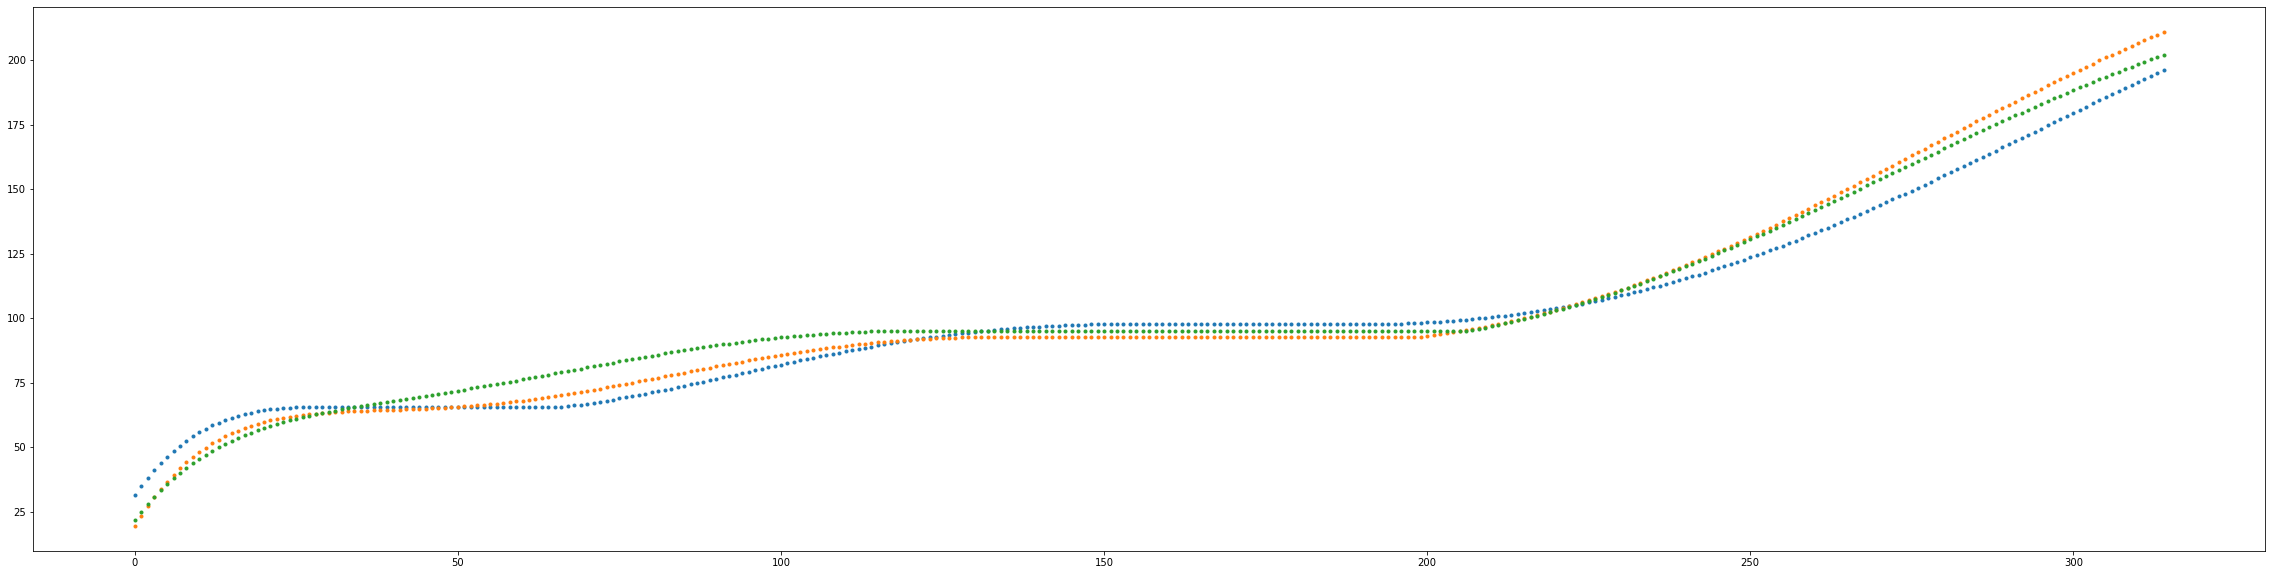

enlarged (15701, 3)


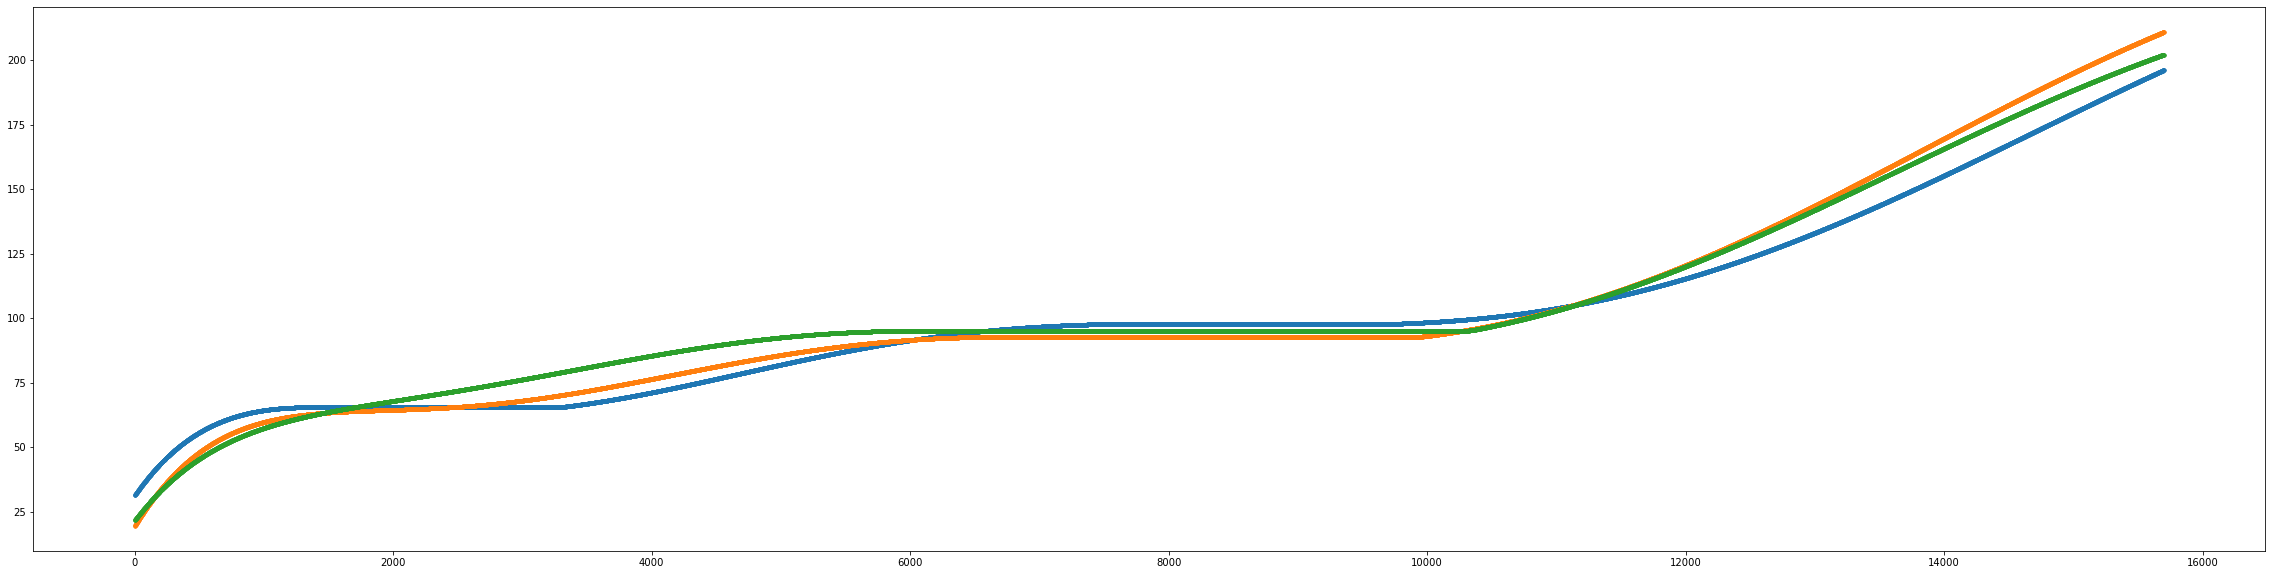

In [3]:
#读取label集，线性插值扩充并存储

import numpy as np
import tensorflow as tf
import tensorflow.contrib.rnn as rnn
import matplotlib.pyplot as plt
import pandas as pd
import random

import xlrd
import xlwt
import time
import os

INTERPOLATION_NUM = 50
LABEL_LOADPATH = 'tool_wear/c4/c4_wear.csv' #训练集标签读取路径    c1,c4
LABEL_SAVEPATH = 'tool_wear/c4_wear.xls' #训练集标签读取路径

def label_interpolation(label_loadpath, label_savepath):
    #数据读取
    label = pd.read_csv(label_loadpath, header = None)
    label = np.array(label)[:, 1:]
    print('original', np.shape(label))
    plt.figure(figsize=(40, 10))
    plt.plot(label,'.')
    plt.show()

    #插值
    x1 = np.linspace(0, np.shape(label)[0]-1, np.shape(label)[0])
    x2 = np.linspace(0, np.shape(label)[0]-1, (np.shape(label)[0]-1)*INTERPOLATION_NUM+1)
    label_interp = np.transpose([np.interp(x2, x1, label[:, 0]), np.interp(x2, x1, label[:, 1]), np.interp(x2, x1, label[:, 2])])

    #写入excel
    f = xlwt.Workbook(encoding = 'ascii')
    sheet1 = f.add_sheet('sheet1',cell_overwrite_ok=True)
    for row in range(np.shape(x2)[0]):
        for col in range(np.shape(label)[1]):
            sheet1.write(row, col, label_interp[row, col])
    f.save(label_savepath)
    
    print('enlarged', np.shape(label_interp))
    plt.figure(figsize=(40, 10))
    plt.plot(label_interp,'.')
    plt.show()

label_interpolation(LABEL_LOADPATH, LABEL_SAVEPATH)

C:\Users\83644\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:103: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


X_train1 (14122, 4096, 7)
label1 (14122, 3)
X_train1 (28520, 4096, 7)
label1 (28520, 3)
X_train1 (14352, 4096, 7)
label1 (14352, 3)


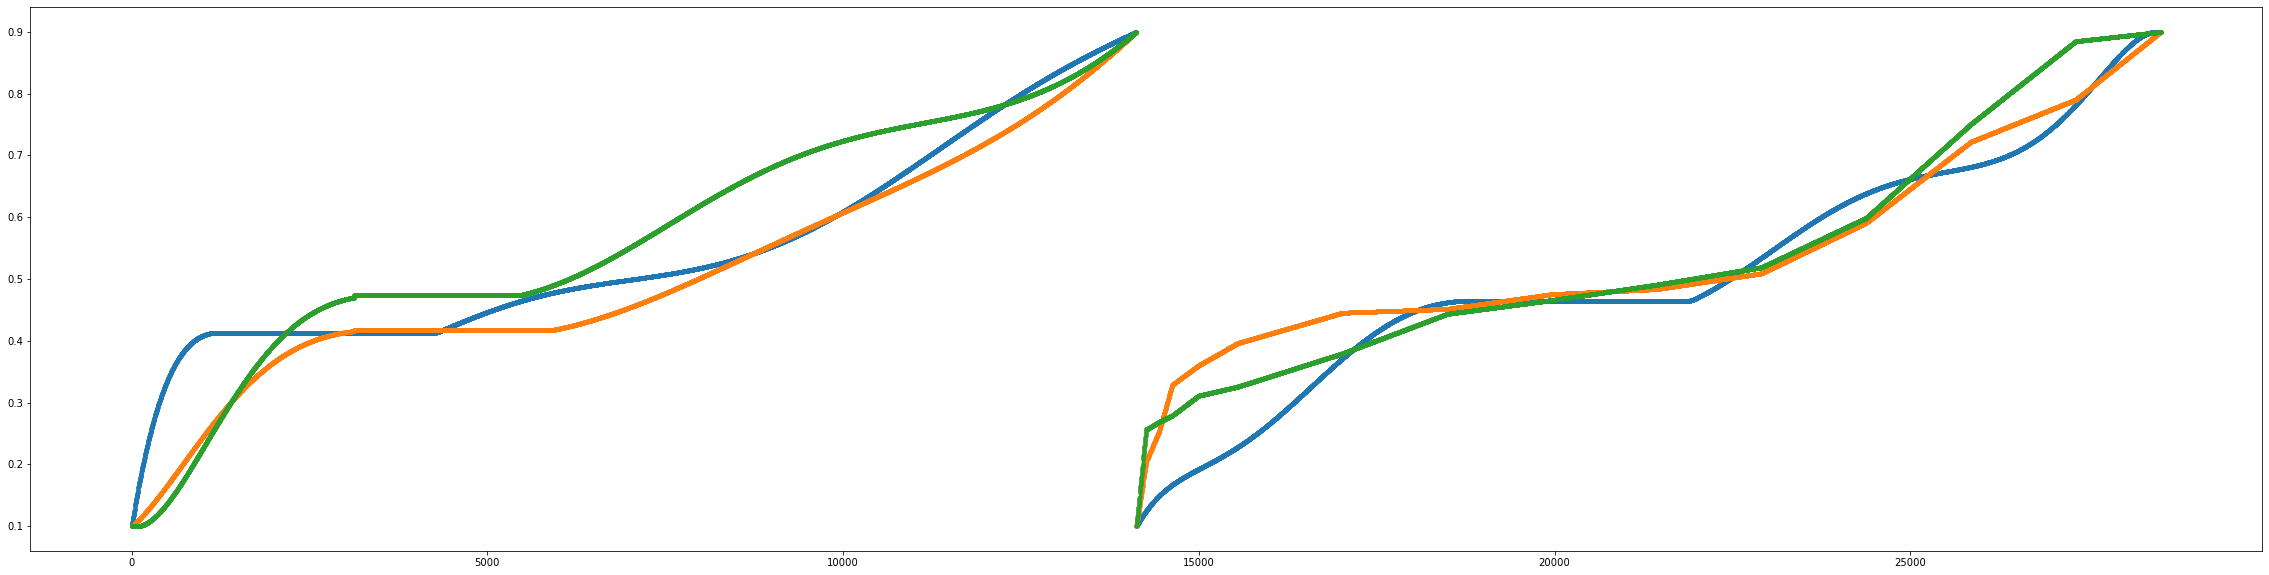

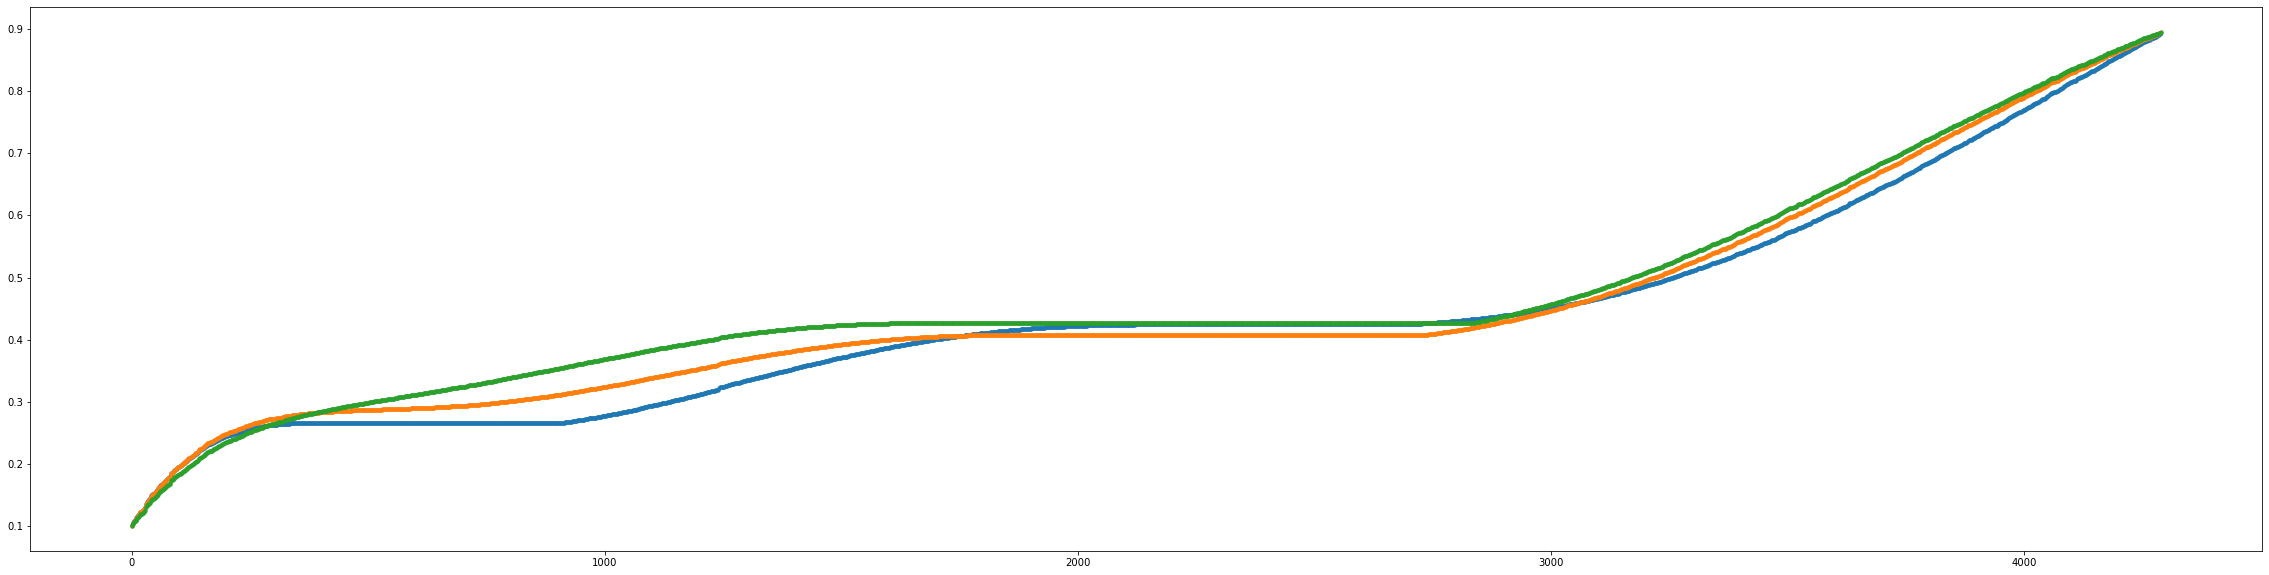

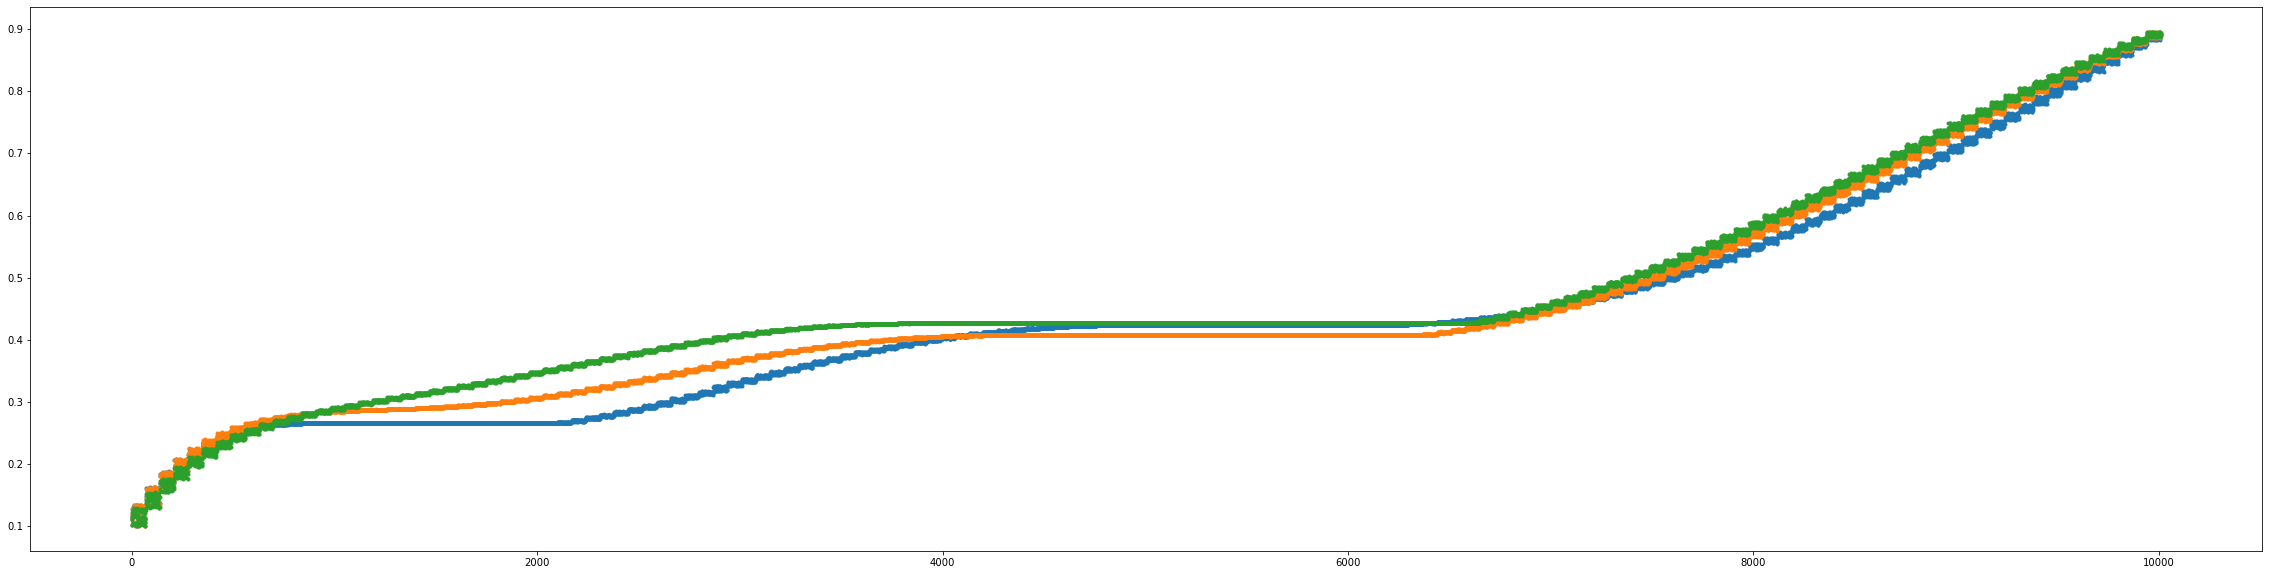

train_data (28520, 4096, 7)
train_label (28520, 3)
validation_data (4290, 4096, 7)
validation_label (4290, 3)
test_data (10010, 4096, 7)
test_label (10010, 3)
time1 =   589.4787888526917


In [1]:
#数据集构建
#需求样本时间跨度过长，导致错误，INTERPOLATION_NUM=50，需要与label集对应 2019.7.24
#功能：将监测数据视为检测阵列。切除数据集data和label上下各一行，左右各5%，删除label为0的data，存储
#输出：train_data, train_label, validation_data, validation_label, test_data, test_label
#信号不再归一化，后续的小波系数再归一化2020.10.16

import numpy as np
import pandas as pd
import random
import scipy.signal
import time
import xlrd
import os
import matplotlib.pyplot as plt


INTERPOLATION_NUM = 50
#OUTPUT_SCALE = 200   #输出缩放系数，LSTM输出在0~1之间

# BLOCK_NUM = 5 #块数量，输出[sample_num, BLOCK_NUM, TIME_STEPS, DATA_CHANNEL]
TIME_STEPS=4096    #所需数据时间序列长度
DATA_CHANNEL=7      #读取原始数据集的通道数

TRAINDATA_LOADPATH = ['tool_wear/c1/c1/c_1_', 'tool_wear/c6/c6/c_6_'] #训练集数据读取路径
TRAINLABEL_LOADPATH = ['tool_wear/c1_wear.xls', 'tool_wear/c6_wear.xls'] #训练集标签读取路径
TESTDATA_LOADPATH = ['tool_wear/c4/c4/c_4_'] #训练集数据读取路径
TESTLABEL_LOADPATH = ['tool_wear/c4_wear.xls'] #训练集标签读取路径

TRAINDATA_SAVEPATH = 'tool_wear_data_1/train_data.npy' #训练集数据存储路径
TRAINLABEL_SAVEPATH = 'tool_wear_data_1/train_label.npy' #训练集标签存储路径
VALIDATIONDATA_SAVEPATH = 'tool_wear_data_1/validation_data.npy' #验证集数据存储路径
VALIDATIONLABEL_SAVEPATH = 'tool_wear_data_1/validation_label.npy' #验证集标签存储路径
TESTDATA_SAVEPATH = 'tool_wear_data_1/test_data.npy' #验证集数据存储路径
TESTLABEL_SAVEPATH =  'tool_wear_data_1/test_label.npy' #验证集标签存储路径

####################################数据读取及处理###################################################################################
#将输入转化为LSTM可用的数据格式[-1, time, item]，插值。输出格式符合[-1, item]，不做改变,若作改变函数详见SOC_LSTM_prediction
#两边的删除量可能需要根据数据段的长短调节，现数值两边各2%
def generate(seq_X):
    X=[]
    total_num = np.shape(seq_X)[0]
#     print(round(total_num*(2+1)/INTERPOLATION_NUM)-TIME_STEPS)
    for i in range(INTERPOLATION_NUM-4):
#         print(i+2+1)
        X.append([seq_X[round(total_num*(i+2+1)/INTERPOLATION_NUM)-TIME_STEPS : round(total_num*(i+2+1)/INTERPOLATION_NUM)]])#去除头尾            
#     print(total_num - round(total_num*(i+2+1)/INTERPOLATION_NUM))
    return np.array(X,dtype=np.float32)

#将原数据按比例随机分为训练集和测试集两部分，ratio测试集占比
def set_segmentation(data, ratio, label):
    segment_length = 100             #单个随机抽样区域长度
    total_num = np.shape(label)[0]
    data = np.array(data[:total_num-total_num%segment_length])
    label = np.array(label[:total_num-total_num%segment_length])
    train_label = []
    train_data = []
    train_index = []
    for i in range(0, total_num-segment_length, segment_length):
        index = random.sample(range(i,i+segment_length), int(segment_length*(1-ratio)))
        train_label.extend(label[index])
        train_data.extend(data[index])
        train_index.extend(index)
    test_label = np.delete(label, train_index, axis = 0)
    test_data = np.delete(data, train_index, axis = 0)
    return train_data, train_label, test_data, test_label

#读取训练集或验证集数据
def train_set_read(data_path, label_path):
    for j in range(len(data_path)):
        #读取label
        workbook = xlrd.open_workbook(label_path[j])
        sheet1 = workbook.sheet_by_index(0)         #用索引取第一个sheet
        #numpy运算先转array，需变二维矩阵，除去第一组label
        label = np.transpose(np.concatenate([np.array([sheet1.col_values(0)]), 
                                             np.array([sheet1.col_values(1)]), 
                                             np.array([sheet1.col_values(2)])], axis=0))[1: -INTERPOLATION_NUM]
        label = label.astype(np.float32)
        delete_index1 = []

        #读取data
        for i in range(2, 315):   #忽略首次和末次切割
            if i < 10:
                data_path1 = data_path[j] + '00' + str(i) + '.csv'
            elif i >= 10 and i < 100:
                data_path1 = data_path[j] + '0' + str(i) + '.csv'
            else:
                data_path1 = data_path[j] + str(i) + '.csv'

            if os.path.getsize(data_path1):  #检验是否为空文件
                train_data_read = pd.read_csv(data_path1, header = None)#这里可加入预处理环节
#                 train_data_read = scipy.signal.medfilt(train_data_read, [3, 1])[::2, 0:DATA_CHANNEL]
                train_data_read = np.array(train_data_read)[:, 0:DATA_CHANNEL]

                if i > 2:  #i的循环起始数，起始循环数+1
                    X_train = np.concatenate([X_train, generate(train_data_read)])
                else:
#                    X_train = generate(train_data_read)/OUTPUT_SCALE
                    X_train = generate(train_data_read)
            else:
                delete_index1 = np.append(delete_index1, list(range((i-2)*INTERPOLATION_NUM, (i-1)*INTERPOLATION_NUM, 1)))
                #print(str(i)+' '+str((i-2)*INTERPOLATION_NUM) + str((i-1)*INTERPOLATION_NUM-1))   #删除有问题的数据
        
        label = np.delete(label,delete_index1,axis = 0)
        delete_index = list(range(0, np.shape(label)[0], INTERPOLATION_NUM)) + \
                                    list(range(1, np.shape(label)[0], INTERPOLATION_NUM)) + \
                                    list(range(2, np.shape(label)[0], INTERPOLATION_NUM)) + \
                                    list(range(49, np.shape(label)[0], INTERPOLATION_NUM))
        label = np.delete(label, delete_index, axis = 0)
        X_train=np.reshape(X_train, [-1, TIME_STEPS, np.shape(train_data_read)[1]])
        #print('X_train', np.shape(X_train))#[29472,30,7]

        max_val = np.max(label, 0)
        min_val = np.min(label, 0)
        label = (label - min_val)/(max_val - min_val)*0.8 + 0.1
#         label = (label - min_val)/(max_val - min_val)*1.6-0.8
        #label1 = label1/300
    
        if j > 0:
            label1 = np.vstack([label1, label])
            X_train1 = np.vstack([X_train1, X_train])
        else:
            label1 = label
            X_train1 = X_train
        print('X_train1', np.shape(X_train1))#[29472,30,7]
        print('label1', np.shape(label1))
        
#         X_train1[:,:,0:3] = X_train1[:,:,0:3]/100
#         X_train1[:,:,3:6] = X_train1[:,:,3:6]*2
#         X_train1[:,:,6] = X_train1[:,:,6]/3
    
    return X_train1, label1

###################################数据存储##########################################################################################
time_start = time.time()
train_data, train_label = train_set_read(TRAINDATA_LOADPATH, TRAINLABEL_LOADPATH)
# train_data = np.reshape(train_data, [-1, BLOCK_NUM, int(TIME_STEPS/BLOCK_NUM), DATA_CHANNEL])
test_data, test_label = train_set_read(TESTDATA_LOADPATH, TESTLABEL_LOADPATH)
test_data, test_label, validation_data, validation_label = set_segmentation(test_data, 0.3, test_label)
# test_data = np.reshape(test_data, [-1, BLOCK_NUM, int(TIME_STEPS/BLOCK_NUM), DATA_CHANNEL])
# validation_data = np.reshape(validation_data, [-1, BLOCK_NUM, int(TIME_STEPS/BLOCK_NUM), DATA_CHANNEL])

plt.figure(figsize=(40, 10))
plt.plot(train_label, '.')
plt.show()
plt.figure(figsize=(40, 10))
plt.plot(validation_label, '.')
plt.show()
plt.figure(figsize=(40, 10))
plt.plot(test_label, '.')
plt.show()

print('train_data', np.shape(train_data))
# print('max_train_data_0', np.max(train_data[:,:,:,0]))
# print('max_train_data_1', np.max(train_data[:,:,:,1]))
# print('max_train_data_2', np.max(train_data[:,:,:,2]))
# print('max_train_data_3', np.max(train_data[:,:,:,3]))
# print('max_train_data_4', np.max(train_data[:,:,:,4]))
# print('max_train_data_5', np.max(train_data[:,:,:,5]))
# print('max_train_data_6', np.max(train_data[:,:,:,6]))

print('train_label', np.shape(train_label))
print('validation_data', np.shape(validation_data))
print('validation_label', np.shape(validation_label))
print('test_data', np.shape(test_data))
print('test_label', np.shape(test_label))

np.save(TRAINDATA_SAVEPATH,train_data)
np.save(TRAINLABEL_SAVEPATH,train_label)
np.save(VALIDATIONDATA_SAVEPATH,validation_data)
np.save(VALIDATIONLABEL_SAVEPATH,validation_label)
np.save(TESTDATA_SAVEPATH,test_data)
np.save(TESTLABEL_SAVEPATH,test_label)

print('time1 =  ', time.time()-time_start)


# 傅里叶变换

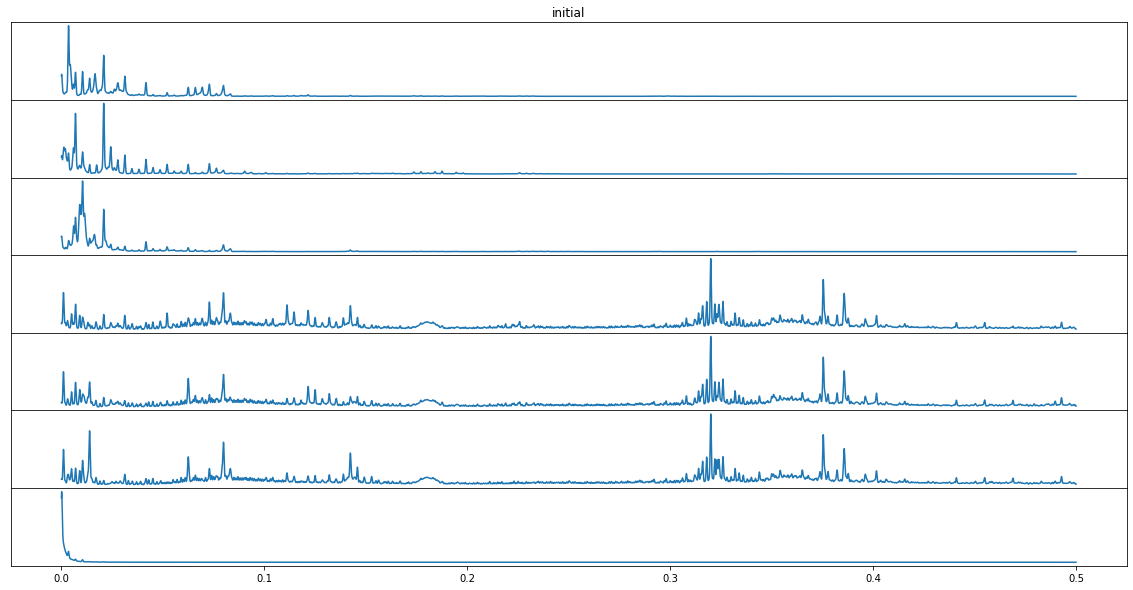

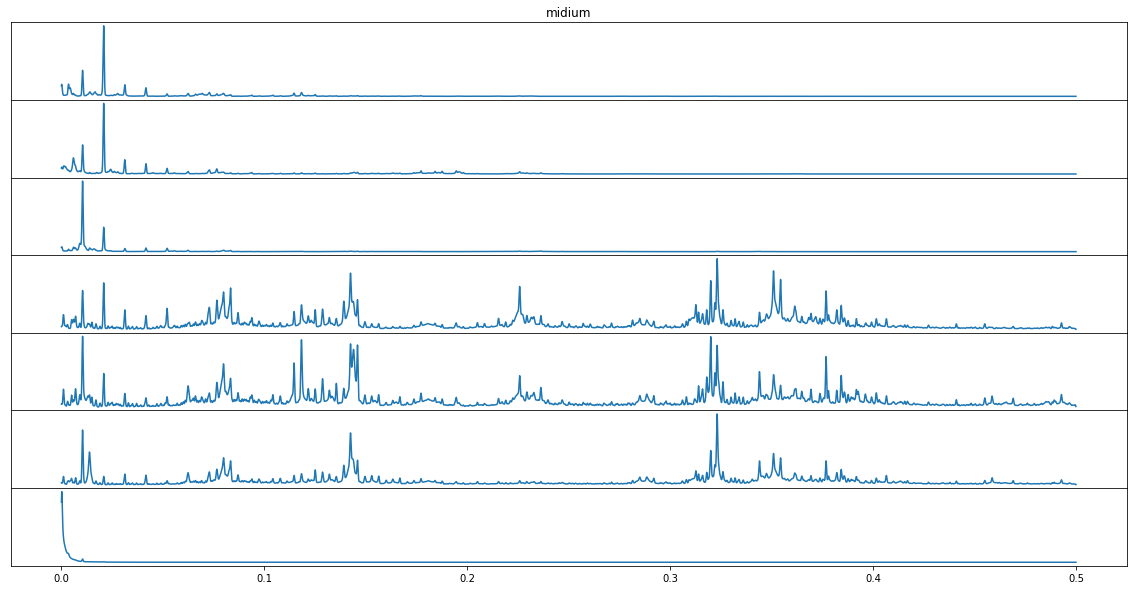

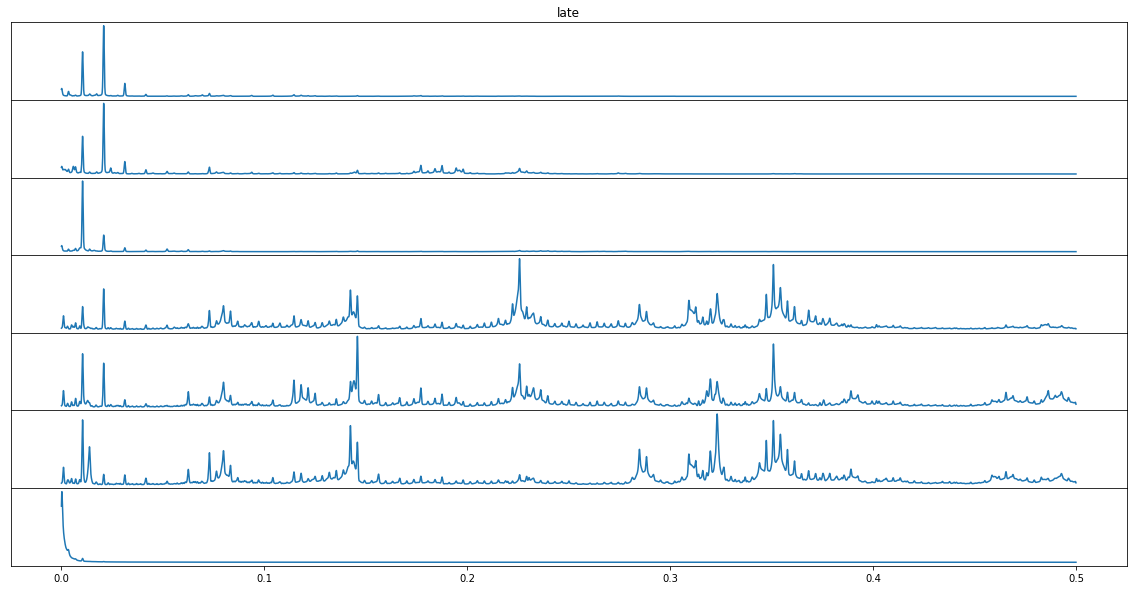

In [1]:
#原始信号在磨损初期、中期和末期的傅里叶频谱图 2020.10.15

import numpy as np
import pandas as pd
import random
import scipy.signal
import time
import xlrd
import os
import matplotlib.pyplot as plt
import numpy.fft as fft


INTERPOLATION_NUM = 10
TIME_STEPS=300    #所需数据时间序列长度
DATA_CHANNEL=7      #读取原始数据集的通道数

DATA_LOADPATH = 'tool_wear/c1/c1/c_1_' #训练集数据读取路径

####################################数据读取及处理###################################################################################
def gaussian_filtering(variation, filter_length, input_x):   #一维高斯滤波，输入均值、方差和输入
    filter_x = np.array(np.arange(-3*variation, 3*variation, 6*variation/filter_length))
#     print('filter_x', np.shape(filter_x))
    gauss_filter = np.exp(-pow(filter_x, 2)/(2*pow(variation, 2)))/(variation*np.sqrt(2*np.pi))
    gauss_filter = gauss_filter/np.sum(gauss_filter)
#     plt.plot(gauss_filter)
#     plt.show()
    filted_signal = np.convolve(input_x, gauss_filter, mode='same')
    return filted_signal
    
#读取训练集或验证集数据
def train_set_read(data_path, index_start, index_stop):
    flag = 0
    for i in range(index_start, index_stop):   #忽略首次和末次切割
        if i < 10:
            data_path1 = data_path + '00' + str(i) + '.csv'
        elif i >= 10 and i < 100:
            data_path1 = data_path + '0' + str(i) + '.csv'
        else:
            data_path1 = data_path + str(i) + '.csv'
        if os.path.getsize(data_path1):  #检验是否为空文件
            train_data_read = np.array(pd.read_csv(data_path1, header = None))#这里可加入预处理环节
            train_data_read = train_data_read[:, 0:DATA_CHANNEL]
#             train_data_read = scipy.signal.medfilt(train_data_read, [11, 1])[::10, 0:DATA_CHANNEL]
            if flag == 0:
                X_train = train_data_read
                flag = 1
            else:
                X_train = np.concatenate([X_train, train_data_read])
    return X_train


###################################数据存储##########################################################################################
time_start = time.time()

def fourier_freq_plot(index_start, index_stop, title): #绘制Fourier频谱，输入起始索引和终止索引
    data1 = train_set_read(DATA_LOADPATH, index_start, index_stop)

    fig_x = 20
    fig_y = 10
    plt.figure(figsize=(fig_x, fig_y))
    plt.subplots_adjust(wspace=0, hspace=0)

    for i in range(7):
        data = data1[:, i]
        complex_array = fft.fft(data)
        # 得到分解波的频率序列
        freqs = fft.fftfreq(np.shape(data)[0])
        # 复数的模为信号的振幅（能量大小）
        pows = np.abs(complex_array)
    #     pows = pow(np.abs(complex_array), 2)
    #     pows = np.convolve(pows, np.ones(100)/100, mode='same')
    #     print(np.shape(pows))
        pows = pows[freqs > 0]
        freqs = freqs[freqs > 0]
        pows = gaussian_filtering(1.5, 1000, pows) #gauss加窗
        plt.subplot(7,1,i+1)
        plt.yticks([])  #去掉纵坐标值
    #     plt.axes(xscale = "log")
        if i != 6:
            plt.xticks([])  #去掉横坐标值
        plt.plot(freqs, pows)
        if i == 0:
            plt.title(title)
    plt.show()
    
fourier_freq_plot(2, 5, 'initial')
fourier_freq_plot(147, 150, 'midium')
fourier_freq_plot(311, 314, 'late')


# 小波变换的不同表示

X_test (9472, 2048, 7)
Y_test (9472, 3)
coeffs2 (9472, 8)
label_interp (9, 1024)


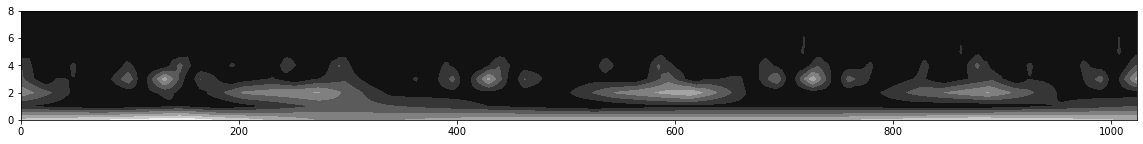

coeffs2 (9472, 8)
label_interp (9, 1024)


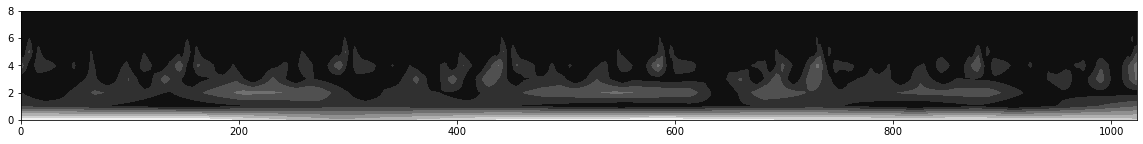

coeffs2 (9472, 8)
label_interp (9, 1024)


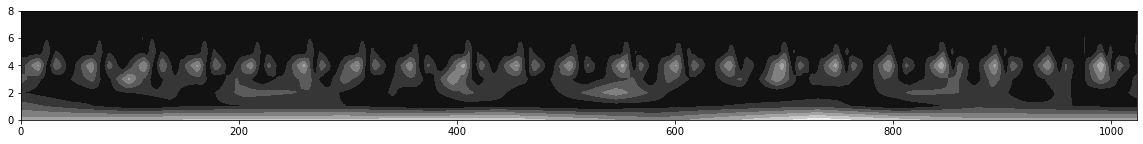

coeffs2 (9472, 8)
label_interp (9, 1024)


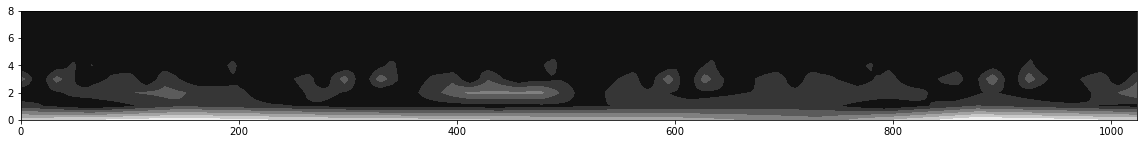

coeffs2 (9472, 8)
label_interp (9, 1024)


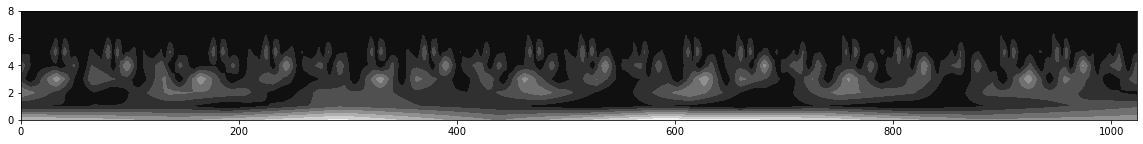

coeffs2 (9472, 8)
label_interp (9, 1024)


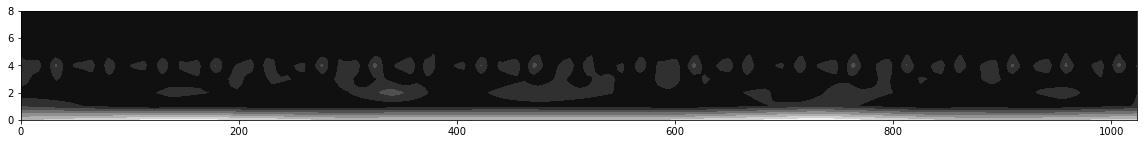

coeffs2 (9472, 8)
label_interp (9, 1024)


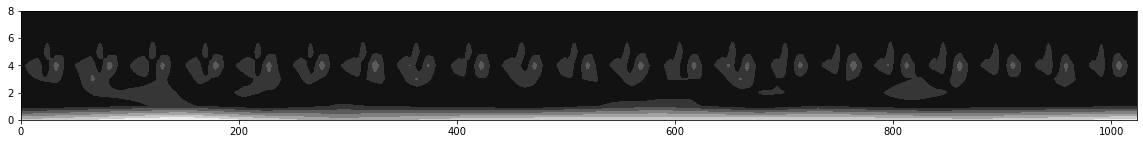

coeffs2 (9472, 8)
label_interp (9, 1024)


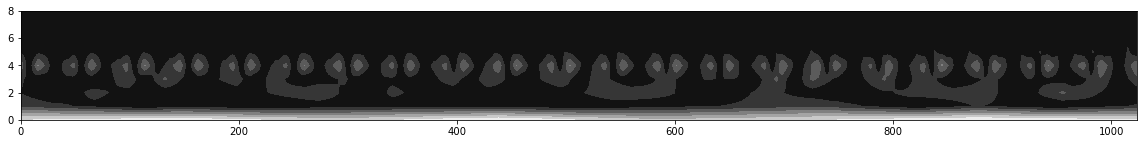

coeffs2 (9472, 8)
label_interp (9, 1024)


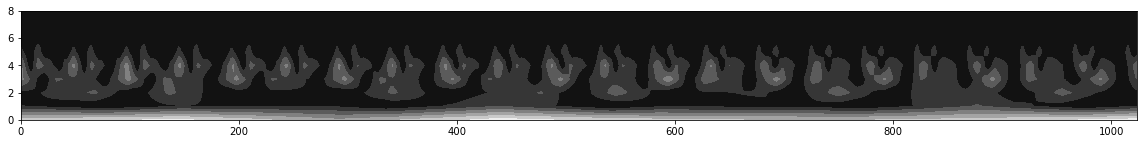

coeffs2 (9472, 8)
label_interp (9, 1024)


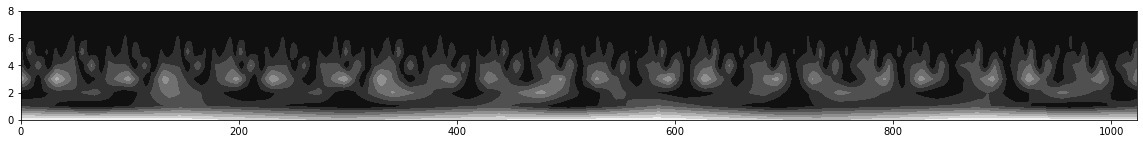

In [4]:
# 一维离散小波变换

import pywt
import numpy as np
from matplotlib import pyplot as plt
from pywt._doc_utils import boundary_mode_subplot
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers, utils, backend
import xlrd
import time
import os

TRAINDATA_LOADPATH = 'tool_wear_data_1/train_data.npy' #训练集数据读取路径
TRAINLABEL_LOADPATH = 'tool_wear_data_1/train_label.npy' #训练集标签读取路径
VALIDATIONDATA_LOADPATH = 'tool_wear_data_1/validation_data.npy' #验证集数据读取路径
VALIDATIONLABEL_LOADPATH =  'tool_wear_data_1/validation_label.npy' #验证集标签读取路径
TESTDATA_LOADPATH = 'tool_wear_data_1/test_data.npy' #验证集数据读取路径
TESTLABEL_LOADPATH =  'tool_wear_data_1/test_label.npy' #验证集标签读取路径
SUMMARY_PATH = './logs'     #记录路径

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"# 这一行注释掉就是使用gpu

#输入数据
INPUT_SIZE = [290, 7]  #[time_steps, input_vector]
TIME_STEPS = INPUT_SIZE[0]
INPUT_NUM = INPUT_SIZE[1]
ENTIRE_INPUT_SIZE = [5, TIME_STEPS, 1]
ENTIRE_TIME_STEPS = ENTIRE_INPUT_SIZE[0] #总共时序长度

OUTPUT_SIZE = 3
BATCH_SIZE = 128
INTERPOLATION_NUM = 50
scale = 8

##############################数据集读取########################################
# X_train=np.load(TRAINDATA_LOADPATH)
# Y_train=np.load(TRAINLABEL_LOADPATH)
# X_validation=np.load(VALIDATIONDATA_LOADPATH)
# Y_validation=np.load(VALIDATIONLABEL_LOADPATH)
X_test=np.load(TESTDATA_LOADPATH)
Y_test=np.load(TESTLABEL_LOADPATH)

#validation_split将样本集按先后比例分为训练集合样本集，样本数量应为两者和的整数倍
# X_train = X_train[:(np.shape(X_train)[0]-np.shape(X_train)[0]%(BATCH_SIZE)), :, :,:INPUT_NUM]
# print('X_train', np.shape(X_train))
# Y_train = Y_train[:(np.shape(Y_train)[0]-np.shape(Y_train)[0]%(BATCH_SIZE)), :OUTPUT_SIZE]
# print('Y_train', np.shape(Y_train))

# X_validation = X_validation[:(np.shape(X_validation)[0]-np.shape(X_validation)[0]%(BATCH_SIZE)),:, :,:INPUT_NUM]
# print('X_validation', np.shape(X_validation))
# Y_validation = Y_validation[:(np.shape(Y_validation)[0]-np.shape(Y_validation)[0]%(BATCH_SIZE)), :OUTPUT_SIZE]
# print('Y_validation', np.shape(Y_validation))

X_test = X_test[:(np.shape(X_test)[0]-np.shape(X_test)[0]%BATCH_SIZE),:, :INPUT_NUM]
Y_test = Y_test[:(np.shape(Y_test)[0]-np.shape(Y_test)[0]%BATCH_SIZE), :OUTPUT_SIZE]
print('X_test', np.shape(X_test))
print('Y_test', np.shape(Y_test))

for j in range(300, np.shape(X_test)[0], 1000):
    sample = X_test[:, :, 1].reshape([-1, np.shape(X_test)[1]])
#     print(np.shape(sample))
    coeffs2 = pywt.wavedec(sample, 'db1', 'symmetric', level=scale)
    print('coeffs2', np.shape(coeffs2[0]))
    for i in range(scale+1):
#         print('coeffs2', np.shape(coeffs2[i]))
    #     print('coeffs2', coeffs2[i][0])
#         print(np.shape(coeffs2[i]))
#         print(np.shape(coeffs2[i])[1])
        x1 = np.linspace(0, np.shape(coeffs2[i])[1]-1, np.shape(coeffs2[i])[1])
        x2 = np.linspace(0, np.shape(coeffs2[i])[1]-1, (np.shape(coeffs2[-1])[1]))

        if i == 0:
            label_interp = np.array([np.interp(x2, x1, coeffs2[i][j])])
        else:
            label_interp = np.concatenate([label_interp, np.array([np.interp(x2, x1, coeffs2[i][j])])], axis=0)

    print('label_interp', np.shape(label_interp))
    plt.figure(figsize=(20,2))
    plt.contourf(abs(label_interp), cmap='gray')
    plt.show()


X_test (5180, 4096, 7)
Y_test (5180, 3)
X_test (5180, 4096)
Y_test (5120, 3)


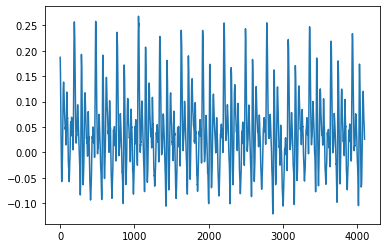

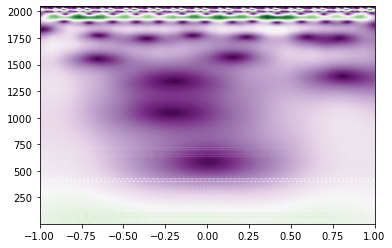

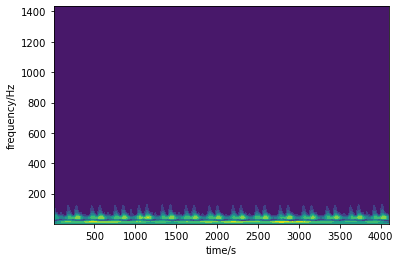

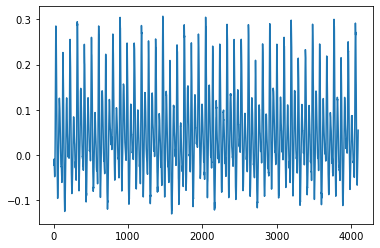

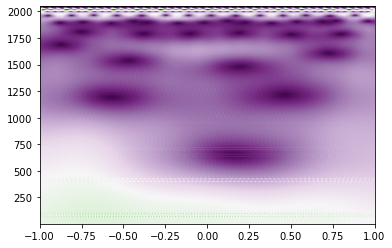

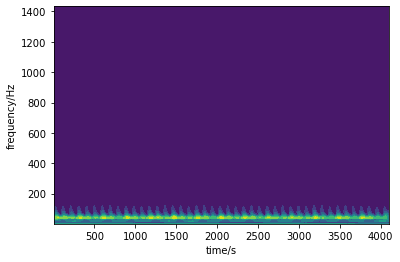

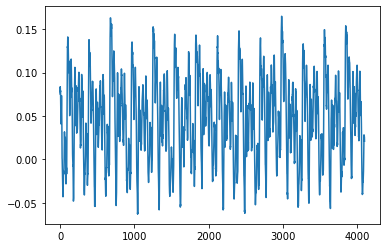

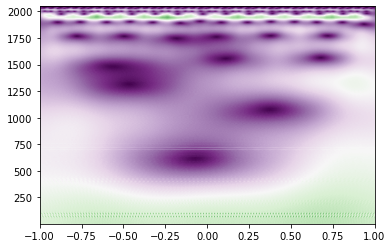

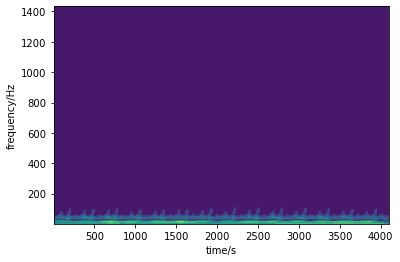

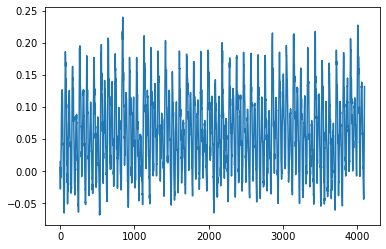

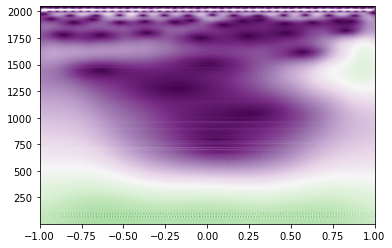

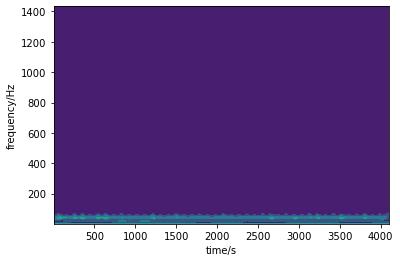

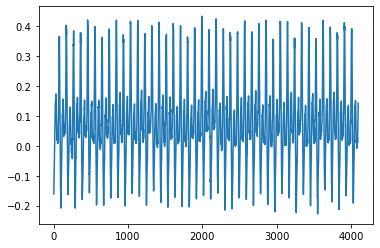

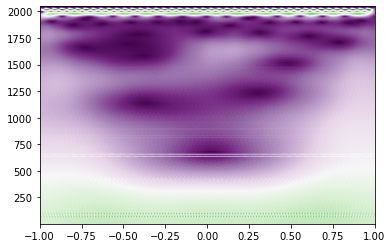

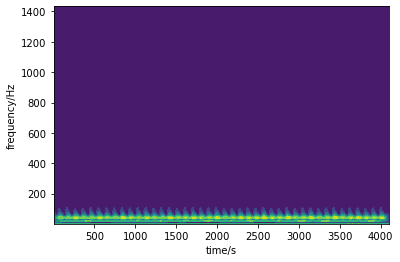

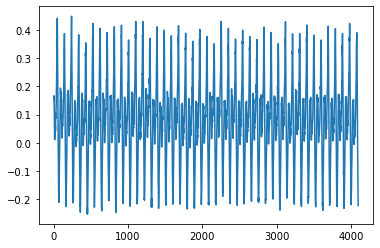

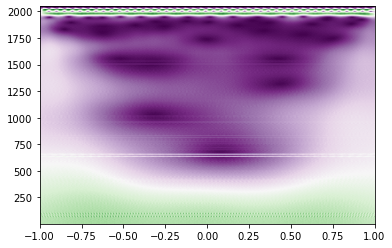

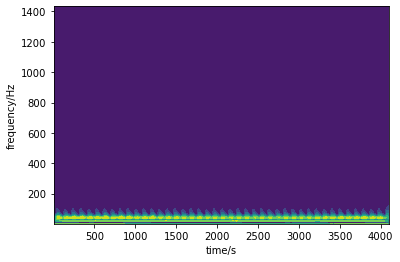

IndexError: index 5300 is out of bounds for axis 0 with size 5180

In [3]:
# 一维连续小波变换

import pywt
import numpy as np
from matplotlib import pyplot as plt
from pywt._doc_utils import boundary_mode_subplot
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers, utils, backend
import xlrd
import time
import os

TRAINDATA_LOADPATH = 'tool_wear_data_1/train_data.npy' #训练集数据读取路径
TRAINLABEL_LOADPATH = 'tool_wear_data_1/train_label.npy' #训练集标签读取路径
VALIDATIONDATA_LOADPATH = 'tool_wear_data_1/validation_data.npy' #验证集数据读取路径
VALIDATIONLABEL_LOADPATH =  'tool_wear_data_1/validation_label.npy' #验证集标签读取路径
TESTDATA_LOADPATH = 'tool_wear_data_1/test_data.npy' #验证集数据读取路径
TESTLABEL_LOADPATH =  'tool_wear_data_1/test_label.npy' #验证集标签读取路径
SUMMARY_PATH = './logs'     #记录路径

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"# 这一行注释掉就是使用gpu

#输入数据
INPUT_SIZE = [290, 1]  #[time_steps, input_vector]
TIME_STEPS = INPUT_SIZE[0]
INPUT_NUM = INPUT_SIZE[1]
ENTIRE_INPUT_SIZE = [5, TIME_STEPS, 1]
ENTIRE_TIME_STEPS = ENTIRE_INPUT_SIZE[0] #总共时序长度

OUTPUT_SIZE = 3
BATCH_SIZE = 128
INTERPOLATION_NUM = 50

##############################数据集读取########################################
# X_train=np.load(TRAINDATA_LOADPATH)
# Y_train=np.load(TRAINLABEL_LOADPATH)
# X_validation=np.load(VALIDATIONDATA_LOADPATH)
# Y_validation=np.load(VALIDATIONLABEL_LOADPATH)
X_test=np.load(TESTDATA_LOADPATH)
Y_test=np.load(TESTLABEL_LOADPATH)
print('X_test', np.shape(X_test))
print('Y_test', np.shape(Y_test))

#validation_split将样本集按先后比例分为训练集合样本集，样本数量应为两者和的整数倍
# X_train = X_train[:(np.shape(X_train)[0]-np.shape(X_train)[0]%(BATCH_SIZE)), :, :,:INPUT_NUM]
# print('X_train', np.shape(X_train))
# Y_train = Y_train[:(np.shape(Y_train)[0]-np.shape(Y_train)[0]%(BATCH_SIZE)), :OUTPUT_SIZE]
# print('Y_train', np.shape(Y_train))

# X_validation = X_validation[:(np.shape(X_validation)[0]-np.shape(X_validation)[0]%(BATCH_SIZE)),:, :,:INPUT_NUM]
# print('X_validation', np.shape(X_validation))
# Y_validation = Y_validation[:(np.shape(Y_validation)[0]-np.shape(Y_validation)[0]%(BATCH_SIZE)), :OUTPUT_SIZE]
# print('Y_validation', np.shape(Y_validation))

# X_test = X_test[:(np.shape(X_test)[0]-np.shape(X_test)[0]%BATCH_SIZE),:, :INPUT_NUM]
X_test = X_test[:, :, 1].reshape([-1, np.shape(X_test)[1]])
print('X_test', np.shape(X_test))
Y_test = Y_test[:(np.shape(Y_test)[0]-np.shape(Y_test)[0]%BATCH_SIZE), :OUTPUT_SIZE]
print('Y_test', np.shape(Y_test))

for i in range(500, 9200, 800):
#     plt.figure(figsize=(15, 3))
    plt.plot(X_test[i, :])
    plt.show()
    
    coeffs2, freqs=pywt.cwt(X_test[i, :], np.arange(1,np.int(np.shape(X_test)[1]/2)), 'cgau8', 2.0 / np.shape(X_test)[1])
#     plt.matshow(abs(coeffs2))
#     plt.figure(figsize=(15, 3))
    plt.imshow(abs(coeffs2), extent=[-1, 1, 1, np.int(np.shape(X_test)[1]/2)], cmap='PRGn', aspect='auto')  # doctest: +SKIP
    plt.show()

#     plt.figure(figsize=(15, 3))
    plt.contourf(np.arange(1,np.int(np.shape(X_test)[1])+1), freqs, abs(coeffs2))
    plt.ylabel('frequency/Hz')
    plt.xlabel('time/s')
    plt.show()
    

X_train (28416, 4096, 7)
Y_train (28416, 3)
X_validation (4224, 4096, 7)
Y_validation (4224, 3)
X_test (9984, 4096, 7)
Y_test (9984, 3)
0 (9984, 16)
1 (9984, 16)
2 (9984, 32)
3 (9984, 64)
4 (9984, 128)
5 (9984, 256)
6 (9984, 512)
7 (9984, 1024)
8 (9984, 2048)
label_interp (7, 2048)


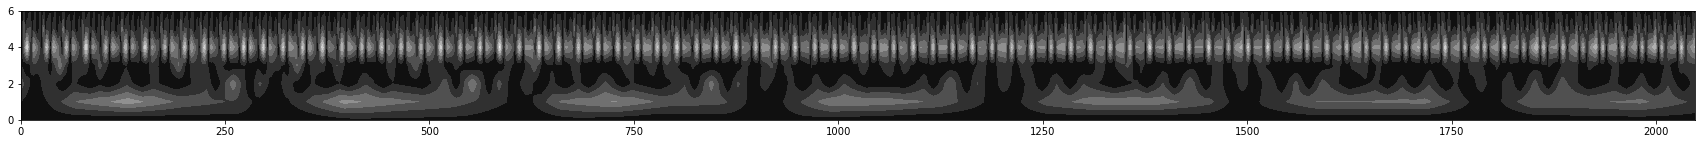

0 (9984, 16)
1 (9984, 16)
2 (9984, 32)
3 (9984, 64)
4 (9984, 128)
5 (9984, 256)
6 (9984, 512)
7 (9984, 1024)
8 (9984, 2048)
label_interp (7, 2048)


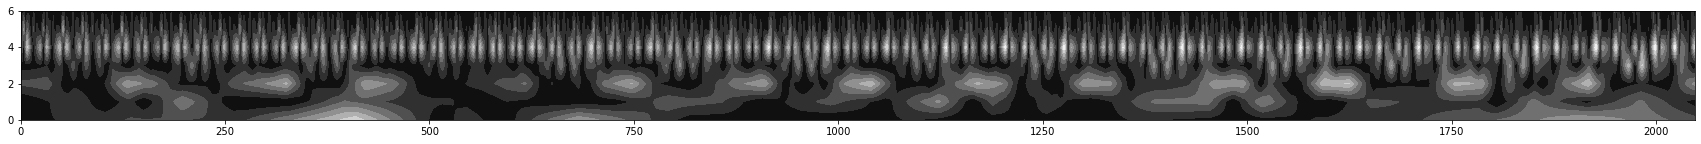

0 (9984, 16)
1 (9984, 16)
2 (9984, 32)
3 (9984, 64)
4 (9984, 128)
5 (9984, 256)
6 (9984, 512)
7 (9984, 1024)
8 (9984, 2048)
label_interp (7, 2048)


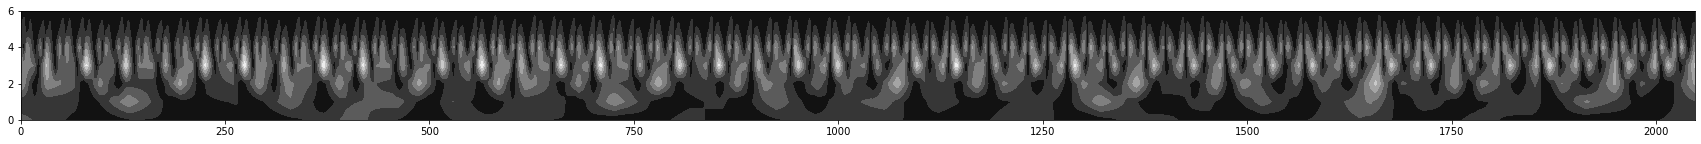

0 (9984, 16)
1 (9984, 16)
2 (9984, 32)
3 (9984, 64)
4 (9984, 128)
5 (9984, 256)
6 (9984, 512)
7 (9984, 1024)
8 (9984, 2048)
label_interp (7, 2048)


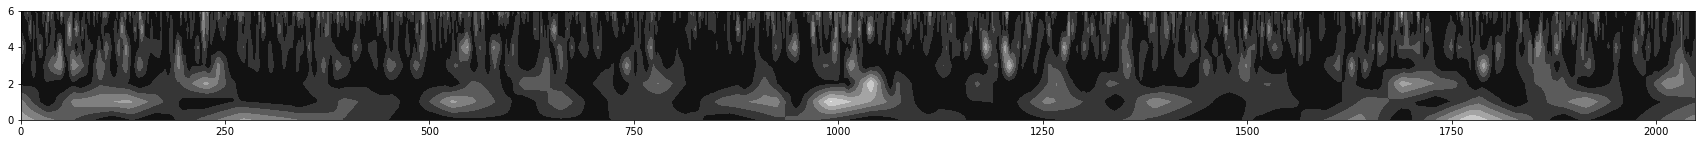

0 (9984, 16)
1 (9984, 16)
2 (9984, 32)
3 (9984, 64)
4 (9984, 128)
5 (9984, 256)
6 (9984, 512)
7 (9984, 1024)
8 (9984, 2048)
label_interp (7, 2048)


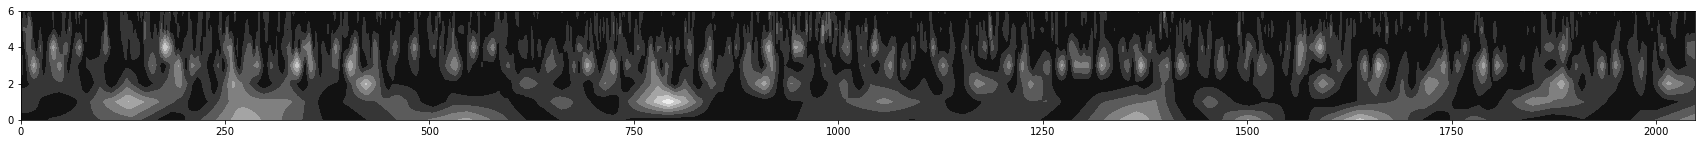

0 (9984, 16)
1 (9984, 16)
2 (9984, 32)
3 (9984, 64)
4 (9984, 128)
5 (9984, 256)
6 (9984, 512)
7 (9984, 1024)
8 (9984, 2048)
label_interp (7, 2048)


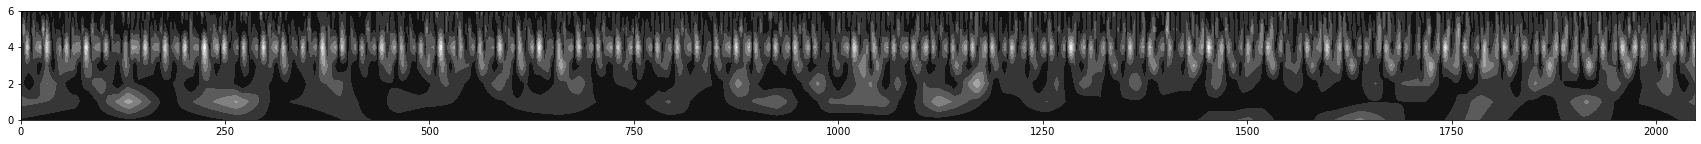

0 (9984, 16)
1 (9984, 16)
2 (9984, 32)
3 (9984, 64)
4 (9984, 128)
5 (9984, 256)
6 (9984, 512)
7 (9984, 1024)
8 (9984, 2048)
label_interp (7, 2048)


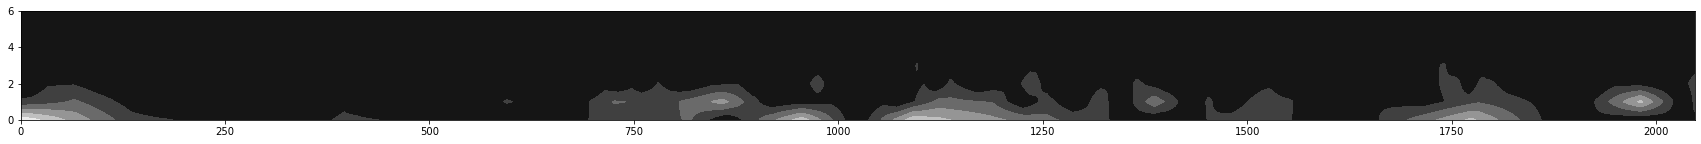

0 (9984, 7, 16)
1 (9984, 7, 16)
2 (9984, 7, 32)
3 (9984, 7, 64)
4 (9984, 7, 128)
5 (9984, 7, 256)
6 (9984, 7, 512)
7 (9984, 7, 1024)
8 (9984, 7, 2048)


In [1]:
# 一维离散小波变换
#可以考虑对不同传感器信号采用不同的频带

import pywt
import numpy as np
from matplotlib import pyplot as plt
from pywt._doc_utils import boundary_mode_subplot
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers, utils, backend
import xlrd
import time
import os

TRAINDATA_LOADPATH = 'tool_wear_data_1/train_data.npy' #训练集数据读取路径
TRAINLABEL_LOADPATH = 'tool_wear_data_1/train_label.npy' #训练集标签读取路径
VALIDATIONDATA_LOADPATH = 'tool_wear_data_1/validation_data.npy' #验证集数据读取路径
VALIDATIONLABEL_LOADPATH =  'tool_wear_data_1/validation_label.npy' #验证集标签读取路径
TESTDATA_LOADPATH = 'tool_wear_data_1/test_data.npy' 
#验证集数据读取路径
TESTLABEL_LOADPATH =  'tool_wear_data_1/test_label.npy' #验证集标签读取路径
SUMMARY_PATH = './logs'     #记录路径

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"# 这一行注释掉就是使用gpu

#输入数据
INPUT_SIZE = [290, 7]  #[time_steps, input_vector]
TIME_STEPS = INPUT_SIZE[0]
INPUT_NUM = INPUT_SIZE[1]
ENTIRE_INPUT_SIZE = [5, TIME_STEPS, 1]
ENTIRE_TIME_STEPS = ENTIRE_INPUT_SIZE[0] #总共时序长度

OUTPUT_SIZE = 3
BATCH_SIZE = 128
INTERPOLATION_NUM = 50
SCALE_NUM = 8 #小波分解级数
SCALE_NUM2 = SCALE_NUM #显示级数

##############################数据集读取########################################
X_train=np.load(TRAINDATA_LOADPATH)
Y_train=np.load(TRAINLABEL_LOADPATH)
X_validation=np.load(VALIDATIONDATA_LOADPATH)
Y_validation=np.load(VALIDATIONLABEL_LOADPATH)
X_test=np.load(TESTDATA_LOADPATH)
Y_test=np.load(TESTLABEL_LOADPATH)

#validation_split将样本集按先后比例分为训练集合样本集，样本数量应为两者和的整数倍
X_train = X_train[:(np.shape(X_train)[0]-np.shape(X_train)[0]%(BATCH_SIZE)), :,:INPUT_NUM]
print('X_train', np.shape(X_train))
Y_train = Y_train[:(np.shape(Y_train)[0]-np.shape(Y_train)[0]%(BATCH_SIZE)), :OUTPUT_SIZE]
print('Y_train', np.shape(Y_train))

X_validation = X_validation[:(np.shape(X_validation)[0]-np.shape(X_validation)[0]%(BATCH_SIZE)),:,:INPUT_NUM]
print('X_validation', np.shape(X_validation))
Y_validation = Y_validation[:(np.shape(Y_validation)[0]-np.shape(Y_validation)[0]%(BATCH_SIZE)), :OUTPUT_SIZE]
print('Y_validation', np.shape(Y_validation))

X_test = X_test[:(np.shape(X_test)[0]-np.shape(X_test)[0]%BATCH_SIZE),:, :INPUT_NUM]
Y_test = Y_test[:(np.shape(Y_test)[0]-np.shape(Y_test)[0]%BATCH_SIZE), :OUTPUT_SIZE]
print('X_test', np.shape(X_test))
print('Y_test', np.shape(Y_test))


sample_index = 5000
for j in range(INPUT_NUM):
    sample = X_test[:, :, j].reshape([-1, np.shape(X_test)[1]])
#     print(np.shape(sample))
    coeffs2 = pywt.wavedec(sample, 'db1', 'symmetric', level=SCALE_NUM)
    print('0', np.shape(coeffs2[0]))
    print('1', np.shape(coeffs2[1]))
    print('2', np.shape(coeffs2[2]))
    print('3', np.shape(coeffs2[3]))
    print('4', np.shape(coeffs2[4]))
    print('5', np.shape(coeffs2[5]))
    print('6', np.shape(coeffs2[6]))
    print('7', np.shape(coeffs2[7]))
    print('8', np.shape(coeffs2[8]))
#     print('9', np.shape(coeffs2[9]))
#     print('10', np.shape(coeffs2[10]))
    
    #提取小波变换系数
    if j == 0:
        coeffs_scale_0 = np.array(coeffs2[0]).reshape([np.shape(sample)[0], 1, np.shape(coeffs2[0])[1]])
        coeffs_scale_1 = np.array(coeffs2[1]).reshape([np.shape(sample)[0], 1, np.shape(coeffs2[1])[1]])
        coeffs_scale_2 = np.array(coeffs2[2]).reshape([np.shape(sample)[0], 1, np.shape(coeffs2[2])[1]])
        coeffs_scale_3 = np.array(coeffs2[3]).reshape([np.shape(sample)[0], 1, np.shape(coeffs2[3])[1]])
        coeffs_scale_4 = np.array(coeffs2[4]).reshape([np.shape(sample)[0], 1, np.shape(coeffs2[4])[1]])
        coeffs_scale_5 = np.array(coeffs2[5]).reshape([np.shape(sample)[0], 1, np.shape(coeffs2[5])[1]])
        coeffs_scale_6 = np.array(coeffs2[6]).reshape([np.shape(sample)[0], 1, np.shape(coeffs2[6])[1]])
        coeffs_scale_7 = np.array(coeffs2[7]).reshape([np.shape(sample)[0], 1, np.shape(coeffs2[7])[1]])
        coeffs_scale_8 = np.array(coeffs2[8]).reshape([np.shape(sample)[0], 1, np.shape(coeffs2[8])[1]])
#         coeffs_scale_9 = np.array(coeffs2[9]).reshape([np.shape(sample)[0], 1, np.shape(coeffs2[9])[1]])
#         coeffs_scale_10 = np.array(coeffs2[10]).reshape([np.shape(sample)[0], 1, np.shape(coeffs2[10])[1]])

    else:
        coeffs_scale_0 = np.concatenate([coeffs_scale_0, np.array(coeffs2[0]).reshape([np.shape(sample)[0], 1, np.shape(coeffs2[0])[1]])], axis = 1)
        coeffs_scale_1 = np.concatenate([coeffs_scale_1, np.array(coeffs2[1]).reshape([np.shape(sample)[0], 1, np.shape(coeffs2[1])[1]])], axis = 1)
        coeffs_scale_2 = np.concatenate([coeffs_scale_2, np.array(coeffs2[2]).reshape([np.shape(sample)[0], 1, np.shape(coeffs2[2])[1]])], axis = 1)
        coeffs_scale_3 = np.concatenate([coeffs_scale_3, np.array(coeffs2[3]).reshape([np.shape(sample)[0], 1, np.shape(coeffs2[3])[1]])], axis = 1)
        coeffs_scale_4 = np.concatenate([coeffs_scale_4, np.array(coeffs2[4]).reshape([np.shape(sample)[0], 1, np.shape(coeffs2[4])[1]])], axis = 1)
        coeffs_scale_5 = np.concatenate([coeffs_scale_5, np.array(coeffs2[5]).reshape([np.shape(sample)[0], 1, np.shape(coeffs2[5])[1]])], axis = 1)
        coeffs_scale_6 = np.concatenate([coeffs_scale_6, np.array(coeffs2[6]).reshape([np.shape(sample)[0], 1, np.shape(coeffs2[6])[1]])], axis = 1)
        coeffs_scale_7 = np.concatenate([coeffs_scale_7, np.array(coeffs2[7]).reshape([np.shape(sample)[0], 1, np.shape(coeffs2[7])[1]])], axis = 1)
        coeffs_scale_8 = np.concatenate([coeffs_scale_8, np.array(coeffs2[8]).reshape([np.shape(sample)[0], 1, np.shape(coeffs2[8])[1]])], axis = 1)
#         coeffs_scale_9 = np.concatenate([coeffs_scale_9, np.array(coeffs2[9]).reshape([np.shape(sample)[0], 1, np.shape(coeffs2[9])[1]])], axis = 1)
#         coeffs_scale_10 = np.concatenate([coeffs_scale_10, np.array(coeffs2[10]).reshape([np.shape(sample)[0], 1, np.shape(coeffs2[10])[1]])], axis = 1)

    #显示小波变换结果
    for i in range(1, SCALE_NUM2):
        x1 = np.linspace(0, np.shape(coeffs2[i])[1]-1, np.shape(coeffs2[i])[1])
        x2 = np.linspace(0, np.shape(coeffs2[i])[1]-1, np.shape(coeffs2[SCALE_NUM2])[1])
        if i == 1:
            label_interp = np.abs([np.interp(x2, x1, coeffs2[i][sample_index])])
        else:
            label_interp = np.concatenate([label_interp, np.abs([np.interp(x2, x1, coeffs2[i][sample_index])])], axis=0)
    print('label_interp', np.shape(label_interp))
    plt.figure(figsize=(30,2))
    plt.contourf(abs(label_interp), cmap='gray')
    plt.show()
    
print('0', np.shape(coeffs_scale_0))
print('1', np.shape(coeffs_scale_1))
print('2', np.shape(coeffs_scale_2))
print('3', np.shape(coeffs_scale_3))
print('4', np.shape(coeffs_scale_4))
print('5', np.shape(coeffs_scale_5))
print('6', np.shape(coeffs_scale_6))
print('7', np.shape(coeffs_scale_7))
print('8', np.shape(coeffs_scale_8))

    

X_test (9984, 4096, 7)
Y_test (9984, 3)


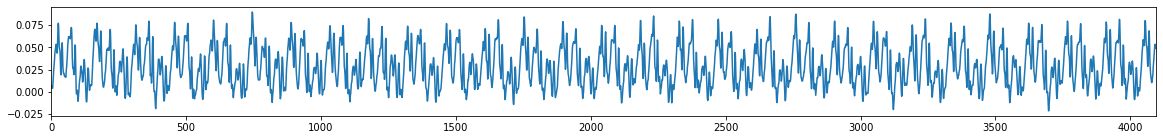

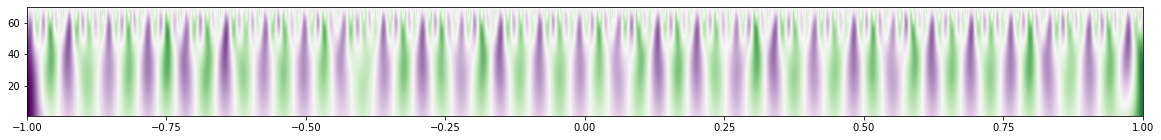

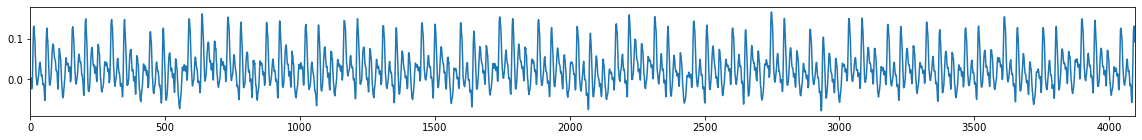

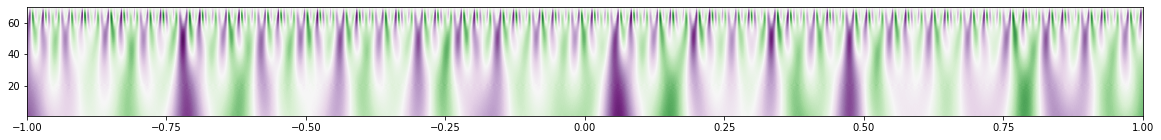

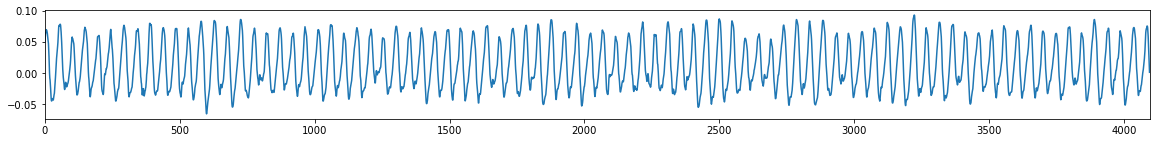

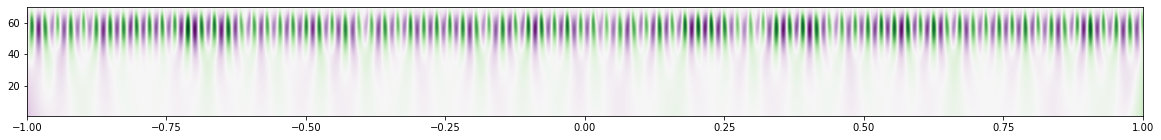

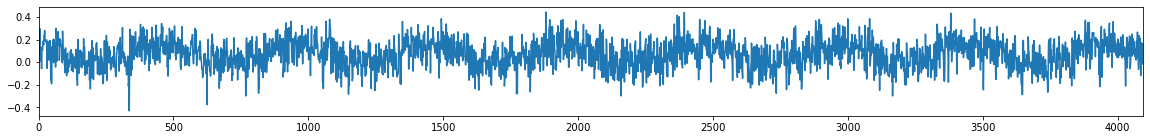

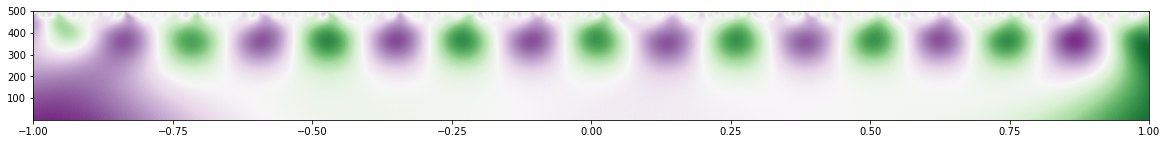

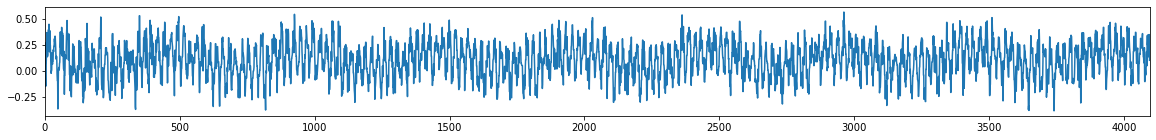

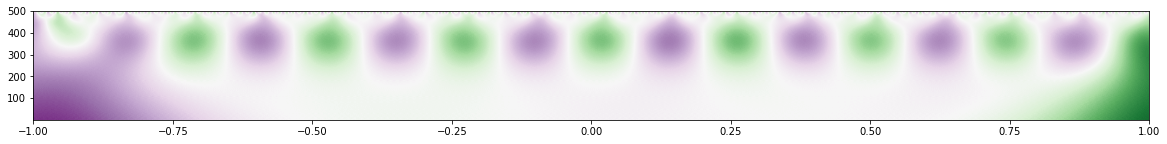

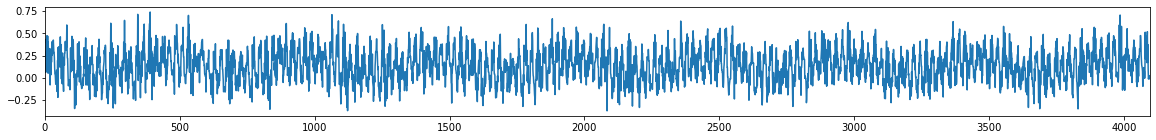

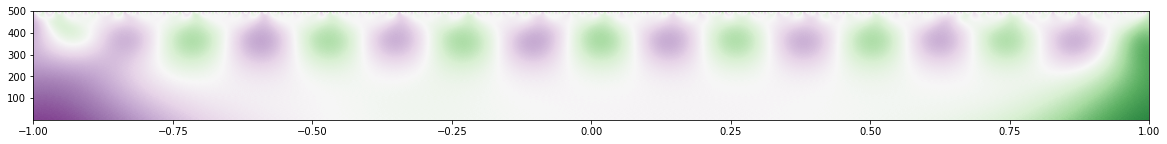

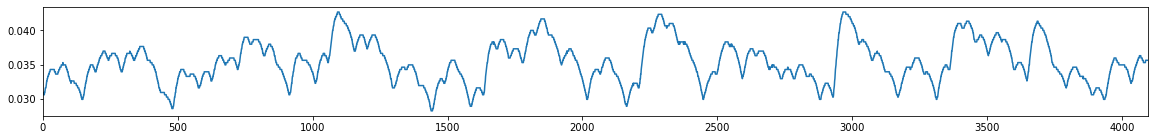

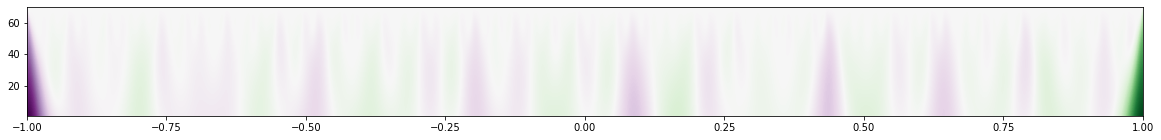

In [1]:
#一维连续小波变换图形展示 https://pywavelets.readthedocs.io/en/latest/ref/cwt.html
# 2020.9.22

import pywt
import numpy as np
import matplotlib.pyplot as plt
import xlrd
import time
import os

TRAINDATA_LOADPATH = 'tool_wear_data_1/train_data.npy' #训练集数据读取路径
TRAINLABEL_LOADPATH = 'tool_wear_data_1/train_label.npy' #训练集标签读取路径
VALIDATIONDATA_LOADPATH = 'tool_wear_data_1/validation_data.npy' #验证集数据读取路径
VALIDATIONLABEL_LOADPATH =  'tool_wear_data_1/validation_label.npy' #验证集标签读取路径
TESTDATA_LOADPATH = 'tool_wear_data_1/test_data.npy' 
#验证集数据读取路径
TESTLABEL_LOADPATH =  'tool_wear_data_1/test_label.npy' #验证集标签读取路径
SUMMARY_PATH = './logs'     #记录路径

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"# 这一行注释掉就是使用gpu

INPUT_SIZE = [290, 7]  #[time_steps, input_vector]
TIME_STEPS = INPUT_SIZE[0]
INPUT_NUM = INPUT_SIZE[1]
ENTIRE_INPUT_SIZE = [5, TIME_STEPS, 1]
ENTIRE_TIME_STEPS = ENTIRE_INPUT_SIZE[0] #总共时序长度

OUTPUT_SIZE = 3
BATCH_SIZE = 128
INTERPOLATION_NUM = 50
SCALE_NUM = 8 #小波分解级数
SCALE_NUM2 = SCALE_NUM-2 #显示级数

X_test=np.load(TESTDATA_LOADPATH)
Y_test=np.load(TESTLABEL_LOADPATH)

X_test = X_test[:(np.shape(X_test)[0]-np.shape(X_test)[0]%BATCH_SIZE),:, :INPUT_NUM]
Y_test = Y_test[:(np.shape(Y_test)[0]-np.shape(Y_test)[0]%BATCH_SIZE), :OUTPUT_SIZE]
print('X_test', np.shape(X_test))
print('Y_test', np.shape(Y_test))


for j in range(INPUT_NUM):
    sample = X_test[100, :, j].reshape(np.shape(X_test)[1])
    x = np.arange(np.shape(sample)[0])
    plt.figure(figsize=(19.8, 2))
    plt.xlim(0, np.shape(x)[0])
    plt.plot(x, sample)
    plt.show()
    
    if j>2 and j<6:
        coef, freqs=pywt.cwt(sample,np.arange(1,500),'gaus1')
        plt.figure(figsize=(20,2))
        plt.imshow(coef, extent=[-1, 1, 1, 500], cmap='PRGn', aspect='auto',
               vmax=abs(coef).max(), vmin=-abs(coef).max())
    else:
        coef, freqs=pywt.cwt(sample,np.arange(1,70),'gaus1')
    #     plt.matshow(coef) # doctest: +SKIP
    #     plt.show() # doctest: +SKIP
        plt.figure(figsize=(20,2))
        plt.imshow(coef, extent=[-1, 1, 1, 70], cmap='PRGn', aspect='auto',
               vmax=abs(coef).max(), vmin=-abs(coef).max())
    plt.show()
    

0 (10010, 516, 7)
1 (10010, 516, 7)
2 (10010, 1027, 7)
3 (10010, 2050, 7)


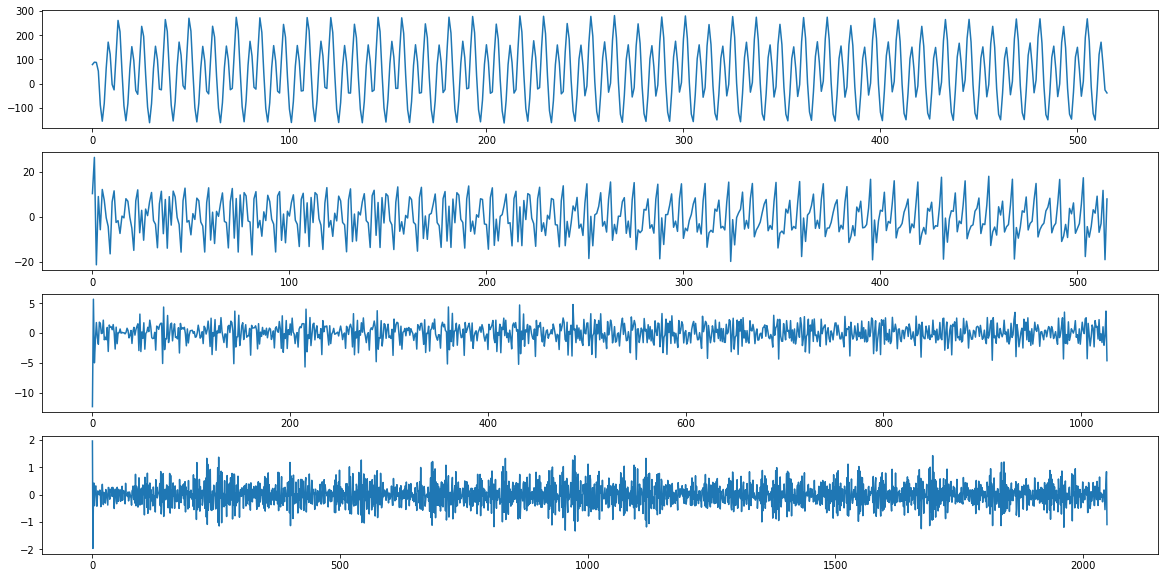

0 (10010, 521, 7)
1 (10010, 521, 7)
2 (10010, 1032, 7)
3 (10010, 2053, 7)


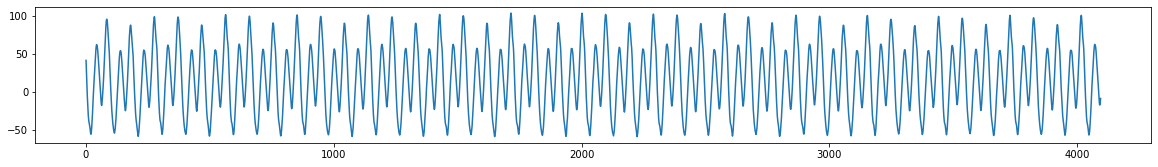

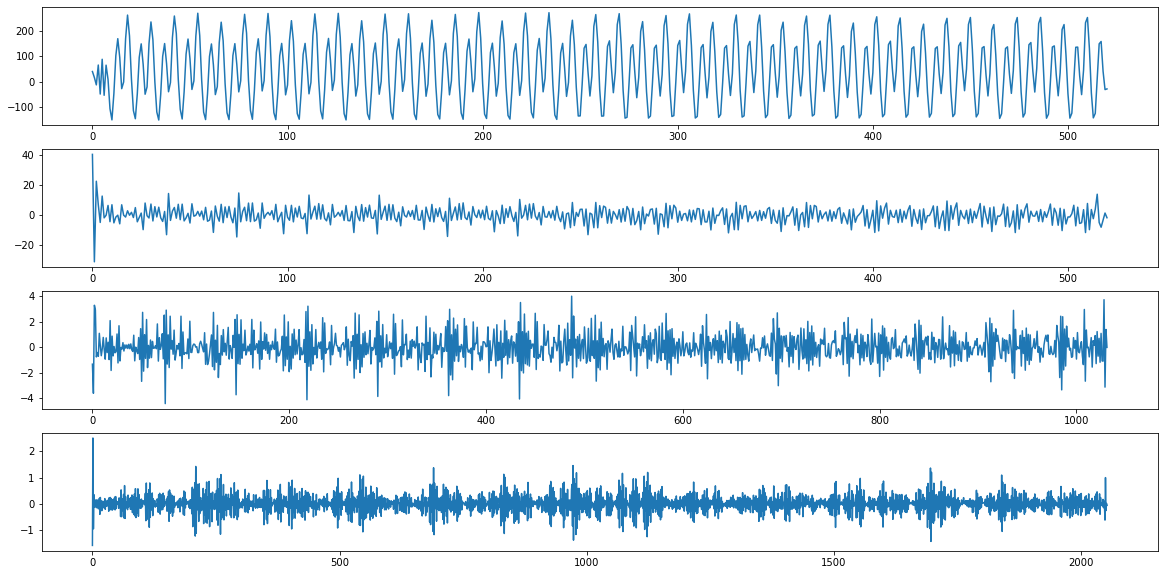

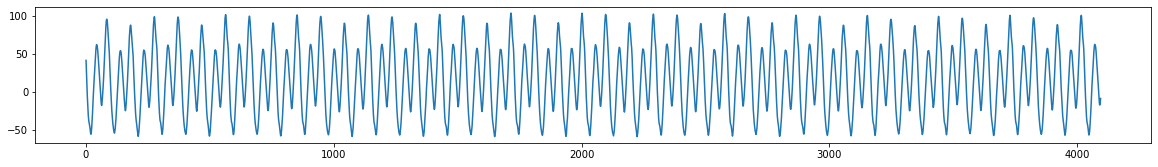

In [1]:
# 一维离散小波变换
#可以考虑对不同传感器信号采用不同的频带

import pywt
import numpy as np
from matplotlib import pyplot as plt
from pywt._doc_utils import boundary_mode_subplot
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers, utils, backend
import xlrd
import time
import os

TRAINDATA_LOADPATH = 'tool_wear_data_1/train_data.npy' #训练集数据读取路径
TRAINLABEL_LOADPATH = 'tool_wear_data_1/train_label.npy' #训练集标签读取路径
VALIDATIONDATA_LOADPATH = 'tool_wear_data_1/validation_data.npy' #验证集数据读取路径
VALIDATIONLABEL_LOADPATH =  'tool_wear_data_1/validation_label.npy' #验证集标签读取路径
TESTDATA_LOADPATH = 'tool_wear_data_1/test_data.npy' 
#验证集数据读取路径
TESTLABEL_LOADPATH =  'tool_wear_data_1/test_label.npy' #验证集标签读取路径
SUMMARY_PATH = './logs'     #记录路径

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"# 这一行注释掉就是使用gpu

INPUT_NUM = 7
SCALE_NUM = 3 #小波分解级数
SCALE_NUM2 = SCALE_NUM #显示级数

sample_index = 80

##############################数据集读取########################################
X_test=np.load(TESTDATA_LOADPATH)
Y_test=np.load(TESTLABEL_LOADPATH)

def percentile_compute(signal): #输入小波信号整体
    for i in range(INPUT_NUM):
        signal1 = signal[-1][:,:,i]
        percentile = np.percentile(np.abs(signal1), 90)
        signal1[np.abs(signal1) < percentile] = 0
        signal[-1][:,:,i] = signal1
    for i in range(INPUT_NUM):
        signal1 = signal[-2][:,:,i]
        percentile = np.percentile(np.abs(signal1), 80)
        signal1[np.abs(signal1) < percentile] = 0
        signal[-2][:,:,i] = signal1
#     print('aaa', np.sum(np.abs(signal1) > 0)/np.shape(signal1)[0] / np.shape(signal1)[1]) 
    return signal

for j in range(INPUT_NUM):
    sample = X_test[:, :, j].reshape([-1, np.shape(X_test)[1]])
#     print(np.shape(sample))
    coeffs2 = pywt.wavedec(sample, 'db6', 'symmetric', level=SCALE_NUM)
#     print('0', np.shape(coeffs2[0]))
#     print('1', np.shape(coeffs2[1]))
#     print('2', np.shape(coeffs2[2]))
#     print('3', np.shape(coeffs2[3]))
#     print('4', np.shape(coeffs2[4]))
#     print('5', np.shape(coeffs2[5]))
#     print('6', np.shape(coeffs2[6]))
#     print('7', np.shape(coeffs2[7]))
#     print('8', np.shape(coeffs2[8]))
    
    #提取小波变换系数
    if j == 0:
        coeffs_scale_0 = np.array(coeffs2[0]).reshape([np.shape(sample)[0], 1, np.shape(coeffs2[0])[1]])
        coeffs_scale_1 = np.array(coeffs2[1]).reshape([np.shape(sample)[0], 1, np.shape(coeffs2[1])[1]])
        coeffs_scale_2 = np.array(coeffs2[2]).reshape([np.shape(sample)[0], 1, np.shape(coeffs2[2])[1]])
        coeffs_scale_3 = np.array(coeffs2[3]).reshape([np.shape(sample)[0], 1, np.shape(coeffs2[3])[1]])
#         coeffs_scale_4 = np.array(coeffs2[4]).reshape([np.shape(sample)[0], 1, np.shape(coeffs2[4])[1]])
#         coeffs_scale_5 = np.array(coeffs2[5]).reshape([np.shape(sample)[0], 1, np.shape(coeffs2[5])[1]])
#         coeffs_scale_6 = np.array(coeffs2[6]).reshape([np.shape(sample)[0], 1, np.shape(coeffs2[6])[1]])
#         coeffs_scale_7 = np.array(coeffs2[7]).reshape([np.shape(sample)[0], 1, np.shape(coeffs2[7])[1]])
#         coeffs_scale_8 = np.array(coeffs2[8]).reshape([np.shape(sample)[0], 1, np.shape(coeffs2[8])[1]])
#         coeffs_scale_9 = np.array(coeffs2[9]).reshape([np.shape(sample)[0], 1, np.shape(coeffs2[9])[1]])
#         coeffs_scale_10 = np.array(coeffs2[10]).reshape([np.shape(sample)[0], 1, np.shape(coeffs2[10])[1]])

    else:
        coeffs_scale_0 = np.concatenate([coeffs_scale_0, np.array(coeffs2[0]).reshape([np.shape(sample)[0], 1, np.shape(coeffs2[0])[1]])], axis = 1)
        coeffs_scale_1 = np.concatenate([coeffs_scale_1, np.array(coeffs2[1]).reshape([np.shape(sample)[0], 1, np.shape(coeffs2[1])[1]])], axis = 1)
        coeffs_scale_2 = np.concatenate([coeffs_scale_2, np.array(coeffs2[2]).reshape([np.shape(sample)[0], 1, np.shape(coeffs2[2])[1]])], axis = 1)
        coeffs_scale_3 = np.concatenate([coeffs_scale_3, np.array(coeffs2[3]).reshape([np.shape(sample)[0], 1, np.shape(coeffs2[3])[1]])], axis = 1)
#         coeffs_scale_4 = np.concatenate([coeffs_scale_4, np.array(coeffs2[4]).reshape([np.shape(sample)[0], 1, np.shape(coeffs2[4])[1]])], axis = 1)
#         coeffs_scale_5 = np.concatenate([coeffs_scale_5, np.array(coeffs2[5]).reshape([np.shape(sample)[0], 1, np.shape(coeffs2[5])[1]])], axis = 1)
#         coeffs_scale_6 = np.concatenate([coeffs_scale_6, np.array(coeffs2[6]).reshape([np.shape(sample)[0], 1, np.shape(coeffs2[6])[1]])], axis = 1)
#         coeffs_scale_7 = np.concatenate([coeffs_scale_7, np.array(coeffs2[7]).reshape([np.shape(sample)[0], 1, np.shape(coeffs2[7])[1]])], axis = 1)
#         coeffs_scale_8 = np.concatenate([coeffs_scale_8, np.array(coeffs2[8]).reshape([np.shape(sample)[0], 1, np.shape(coeffs2[8])[1]])], axis = 1)
#         coeffs_scale_9 = np.concatenate([coeffs_scale_9, np.array(coeffs2[9]).reshape([np.shape(sample)[0], 1, np.shape(coeffs2[9])[1]])], axis = 1)
#         coeffs_scale_10 = np.concatenate([coeffs_scale_10, np.array(coeffs2[10]).reshape([np.shape(sample)[0], 1, np.shape(coeffs2[10])[1]])], axis = 1)
    
a = [0, 1, 2, 3, 4]
a[0] = np.swapaxes(coeffs_scale_0, 1, 2)
a[1] = np.swapaxes(coeffs_scale_1, 1, 2)
a[2] = np.swapaxes(coeffs_scale_2, 1, 2)
a[3] = np.swapaxes(coeffs_scale_3, 1, 2)
# a[4] = np.swapaxes(coeffs_scale_4, 1, 2)
# a[5] = np.swapaxes(coeffs_scale_5, 1, 2)

print('0', np.shape(a[0]))
print('1', np.shape(a[1]))
print('2', np.shape(a[2]))
print('3', np.shape(a[3]))
# print('4', np.shape(a[4]))
# print('5', np.shape(a[5]))

fig_x = 20
fig_y = 10
plt.figure(figsize=(fig_x, fig_y))
# a = percentile_compute(a)
for i in range(SCALE_NUM2+1):
#     print(np.percentile(np.abs(a[i][:,:,0]), 90))
    plt.subplot((SCALE_NUM2+1),1,i+1)
    plt.plot(a[i][sample_index, :, 0])
plt.show()
fig_x = 20
fig_y = 10/(SCALE_NUM2+1)
plt.figure(figsize=(fig_x, fig_y))
plt.plot(X_test[sample_index, :, 0])

0 (10010, 521, 7)
1 (10010, 521, 7)
2 (10010, 1032, 7)
3 (10010, 2053, 7)


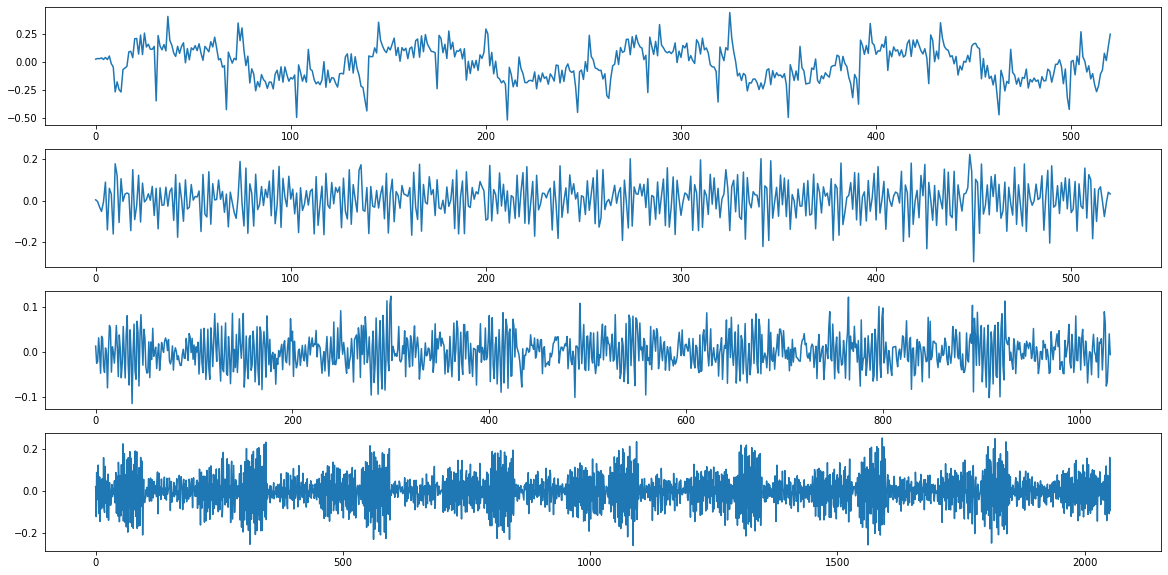

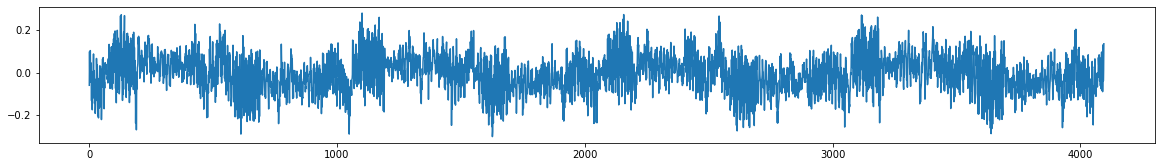

In [1]:
# 一维离散小波变换
#可以考虑对不同传感器信号采用不同的频带

import pywt
import numpy as np
from matplotlib import pyplot as plt
from pywt._doc_utils import boundary_mode_subplot
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers, utils, backend
import xlrd
import time
import os

TRAINDATA_LOADPATH = 'tool_wear_data_1/train_data.npy' #训练集数据读取路径
TRAINLABEL_LOADPATH = 'tool_wear_data_1/train_label.npy' #训练集标签读取路径
VALIDATIONDATA_LOADPATH = 'tool_wear_data_1/validation_data.npy' #验证集数据读取路径
VALIDATIONLABEL_LOADPATH =  'tool_wear_data_1/validation_label.npy' #验证集标签读取路径
TESTDATA_LOADPATH = 'tool_wear_data_1/test_data.npy' 
#验证集数据读取路径
TESTLABEL_LOADPATH =  'tool_wear_data_1/test_label.npy' #验证集标签读取路径
SUMMARY_PATH = './logs'     #记录路径

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"# 这一行注释掉就是使用gpu

INPUT_NUM = 7
SCALE_NUM = 3 #小波分解级数
SCALE_NUM2 = SCALE_NUM #显示级数

##############################数据集读取########################################
X_test=np.load(TESTDATA_LOADPATH)
Y_test=np.load(TESTLABEL_LOADPATH)

sample_index = 100
for j in range(INPUT_NUM):
    sample = X_test[:, :, j].reshape([-1, np.shape(X_test)[1]])
#     print(np.shape(sample))
    coeffs2 = pywt.wavedec(sample, 'db6', 'symmetric', level=SCALE_NUM)
#     print('0', np.shape(coeffs2[0]))
#     print('1', np.shape(coeffs2[1]))
#     print('2', np.shape(coeffs2[2]))
#     print('3', np.shape(coeffs2[3]))
#     print('4', np.shape(coeffs2[4]))
#     print('5', np.shape(coeffs2[5]))
#     print('6', np.shape(coeffs2[6]))
#     print('7', np.shape(coeffs2[7]))
#     print('8', np.shape(coeffs2[8]))
    
    #提取小波变换系数
    if j == 0:
        coeffs_scale_0 = np.array(coeffs2[0]).reshape([np.shape(sample)[0], 1, np.shape(coeffs2[0])[1]])
        coeffs_scale_1 = np.array(coeffs2[1]).reshape([np.shape(sample)[0], 1, np.shape(coeffs2[1])[1]])
        coeffs_scale_2 = np.array(coeffs2[2]).reshape([np.shape(sample)[0], 1, np.shape(coeffs2[2])[1]])
        coeffs_scale_3 = np.array(coeffs2[3]).reshape([np.shape(sample)[0], 1, np.shape(coeffs2[3])[1]])
#         coeffs_scale_4 = np.array(coeffs2[4]).reshape([np.shape(sample)[0], 1, np.shape(coeffs2[4])[1]])
#         coeffs_scale_5 = np.array(coeffs2[5]).reshape([np.shape(sample)[0], 1, np.shape(coeffs2[5])[1]])
#         coeffs_scale_6 = np.array(coeffs2[6]).reshape([np.shape(sample)[0], 1, np.shape(coeffs2[6])[1]])
#         coeffs_scale_7 = np.array(coeffs2[7]).reshape([np.shape(sample)[0], 1, np.shape(coeffs2[7])[1]])
#         coeffs_scale_8 = np.array(coeffs2[8]).reshape([np.shape(sample)[0], 1, np.shape(coeffs2[8])[1]])
#         coeffs_scale_9 = np.array(coeffs2[9]).reshape([np.shape(sample)[0], 1, np.shape(coeffs2[9])[1]])
#         coeffs_scale_10 = np.array(coeffs2[10]).reshape([np.shape(sample)[0], 1, np.shape(coeffs2[10])[1]])

    else:
        coeffs_scale_0 = np.concatenate([coeffs_scale_0, np.array(coeffs2[0]).reshape([np.shape(sample)[0], 1, np.shape(coeffs2[0])[1]])], axis = 1)
        coeffs_scale_1 = np.concatenate([coeffs_scale_1, np.array(coeffs2[1]).reshape([np.shape(sample)[0], 1, np.shape(coeffs2[1])[1]])], axis = 1)
        coeffs_scale_2 = np.concatenate([coeffs_scale_2, np.array(coeffs2[2]).reshape([np.shape(sample)[0], 1, np.shape(coeffs2[2])[1]])], axis = 1)
        coeffs_scale_3 = np.concatenate([coeffs_scale_3, np.array(coeffs2[3]).reshape([np.shape(sample)[0], 1, np.shape(coeffs2[3])[1]])], axis = 1)
#         coeffs_scale_4 = np.concatenate([coeffs_scale_4, np.array(coeffs2[4]).reshape([np.shape(sample)[0], 1, np.shape(coeffs2[4])[1]])], axis = 1)
#         coeffs_scale_5 = np.concatenate([coeffs_scale_5, np.array(coeffs2[5]).reshape([np.shape(sample)[0], 1, np.shape(coeffs2[5])[1]])], axis = 1)
#         coeffs_scale_6 = np.concatenate([coeffs_scale_6, np.array(coeffs2[6]).reshape([np.shape(sample)[0], 1, np.shape(coeffs2[6])[1]])], axis = 1)
#         coeffs_scale_7 = np.concatenate([coeffs_scale_7, np.array(coeffs2[7]).reshape([np.shape(sample)[0], 1, np.shape(coeffs2[7])[1]])], axis = 1)
#         coeffs_scale_8 = np.concatenate([coeffs_scale_8, np.array(coeffs2[8]).reshape([np.shape(sample)[0], 1, np.shape(coeffs2[8])[1]])], axis = 1)
#         coeffs_scale_9 = np.concatenate([coeffs_scale_9, np.array(coeffs2[9]).reshape([np.shape(sample)[0], 1, np.shape(coeffs2[9])[1]])], axis = 1)
#         coeffs_scale_10 = np.concatenate([coeffs_scale_10, np.array(coeffs2[10]).reshape([np.shape(sample)[0], 1, np.shape(coeffs2[10])[1]])], axis = 1)
    
a = [0, 1, 2, 3, 4, 5, 6]
a[0] = np.swapaxes(coeffs_scale_0, 1, 2)
a[1] = np.swapaxes(coeffs_scale_1, 1, 2)
a[2] = np.swapaxes(coeffs_scale_2, 1, 2)
a[3] = np.swapaxes(coeffs_scale_3, 1, 2)
# a[4] = np.swapaxes(coeffs_scale_4, 1, 2)
# a[5] = np.swapaxes(coeffs_scale_5, 1, 2)
# a[6] = np.swapaxes(coeffs_scale_6, 1, 2)

print('0', np.shape(a[0]))
print('1', np.shape(a[1]))
print('2', np.shape(a[2]))
print('3', np.shape(a[3]))
# print('4', np.shape(a[4]))
# print('5', np.shape(a[5]))
# print('6', np.shape(a[6]))

fig_x = 20
fig_y = 10
plt.figure(figsize=(fig_x, fig_y))
for i in range(SCALE_NUM2+1):
#     (a[i][sample_index, :, 3] < np.percentile(a[i][:,:,3], 80)) = 0
    plt.subplot(SCALE_NUM2+1,1,i+1)
    plt.plot(a[i][sample_index, :, 3])
plt.show()
fig_x = 20
fig_y = 10/(SCALE_NUM2+1)
plt.figure(figsize=(fig_x, fig_y))
plt.plot(X_test[sample_index, :, 3])

0 (10010, 266, 7)
1 (10010, 266, 7)
2 (10010, 521, 7)
3 (10010, 1032, 7)
4 (10010, 2053, 7)
0.3209291279315949
0.13595902323722842
0.16491358578205112
0.08884382396936416
0.14022811055183412


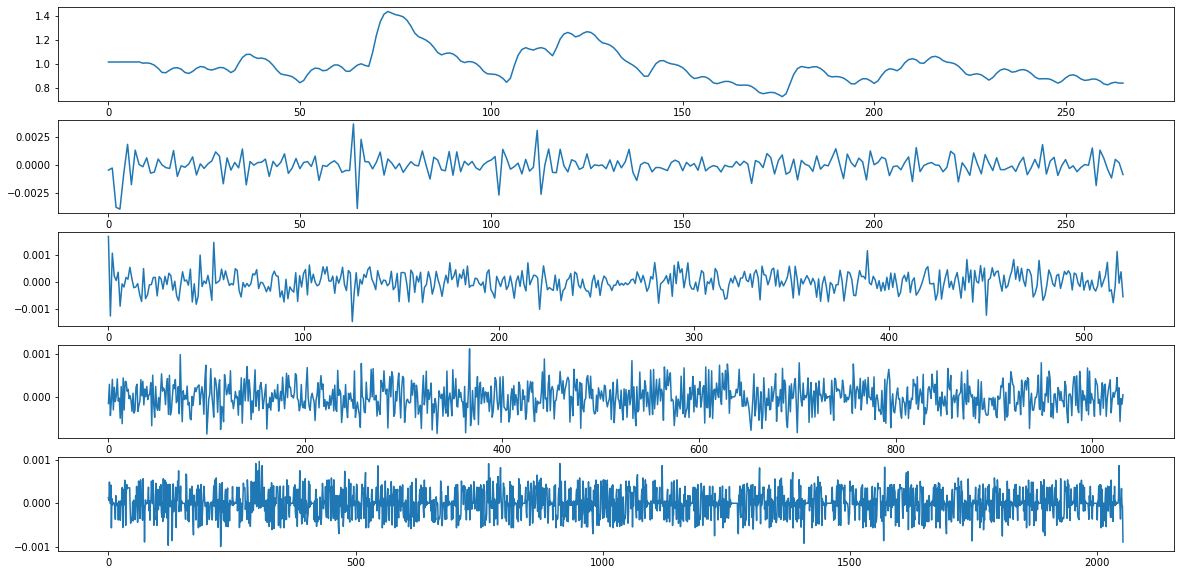

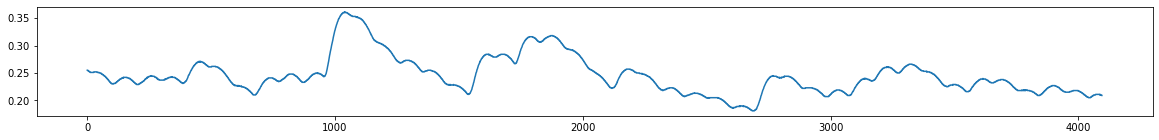

In [3]:
# 一维离散小波变换
#可以考虑对不同传感器信号采用不同的频带

import pywt
import numpy as np
from matplotlib import pyplot as plt
from pywt._doc_utils import boundary_mode_subplot
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers, utils, backend
import xlrd
import time
import os

TRAINDATA_LOADPATH = 'tool_wear_data_1/train_data.npy' #训练集数据读取路径
TRAINLABEL_LOADPATH = 'tool_wear_data_1/train_label.npy' #训练集标签读取路径
VALIDATIONDATA_LOADPATH = 'tool_wear_data_1/validation_data.npy' #验证集数据读取路径
VALIDATIONLABEL_LOADPATH =  'tool_wear_data_1/validation_label.npy' #验证集标签读取路径
TESTDATA_LOADPATH = 'tool_wear_data_1/test_data.npy' 
#验证集数据读取路径
TESTLABEL_LOADPATH =  'tool_wear_data_1/test_label.npy' #验证集标签读取路径
SUMMARY_PATH = './logs'     #记录路径

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"# 这一行注释掉就是使用gpu

#输入数据
INPUT_SIZE = [290, 7]  #[time_steps, input_vector]
TIME_STEPS = INPUT_SIZE[0]
INPUT_NUM = INPUT_SIZE[1]
ENTIRE_INPUT_SIZE = [5, TIME_STEPS, 1]
ENTIRE_TIME_STEPS = ENTIRE_INPUT_SIZE[0] #总共时序长度

OUTPUT_SIZE = 3
BATCH_SIZE = 128
INTERPOLATION_NUM = 50
SCALE_NUM = 4 #小波分解级数
SCALE_NUM2 = SCALE_NUM #显示级数

##############################数据集读取########################################
X_test=np.load(TESTDATA_LOADPATH)
Y_test=np.load(TESTLABEL_LOADPATH)

sample_index = 10000
for j in range(INPUT_NUM):
    sample = X_test[:, :, j].reshape([-1, np.shape(X_test)[1]])
#     print(np.shape(sample))
    coeffs2 = pywt.wavedec(sample, 'db6', 'symmetric', level=SCALE_NUM)
#     print('0', np.shape(coeffs2[0]))
#     print('1', np.shape(coeffs2[1]))
#     print('2', np.shape(coeffs2[2]))
#     print('3', np.shape(coeffs2[3]))
#     print('4', np.shape(coeffs2[4]))
#     print('5', np.shape(coeffs2[5]))
#     print('6', np.shape(coeffs2[6]))
#     print('7', np.shape(coeffs2[7]))
#     print('8', np.shape(coeffs2[8]))
    
    #提取小波变换系数
    if j == 0:
        coeffs_scale_0 = np.array(coeffs2[0]).reshape([np.shape(sample)[0], 1, np.shape(coeffs2[0])[1]])
        coeffs_scale_1 = np.array(coeffs2[1]).reshape([np.shape(sample)[0], 1, np.shape(coeffs2[1])[1]])
        coeffs_scale_2 = np.array(coeffs2[2]).reshape([np.shape(sample)[0], 1, np.shape(coeffs2[2])[1]])
        coeffs_scale_3 = np.array(coeffs2[3]).reshape([np.shape(sample)[0], 1, np.shape(coeffs2[3])[1]])
        coeffs_scale_4 = np.array(coeffs2[4]).reshape([np.shape(sample)[0], 1, np.shape(coeffs2[4])[1]])
#         coeffs_scale_5 = np.array(coeffs2[5]).reshape([np.shape(sample)[0], 1, np.shape(coeffs2[5])[1]])
#         coeffs_scale_6 = np.array(coeffs2[6]).reshape([np.shape(sample)[0], 1, np.shape(coeffs2[6])[1]])
#         coeffs_scale_7 = np.array(coeffs2[7]).reshape([np.shape(sample)[0], 1, np.shape(coeffs2[7])[1]])
#         coeffs_scale_8 = np.array(coeffs2[8]).reshape([np.shape(sample)[0], 1, np.shape(coeffs2[8])[1]])
#         coeffs_scale_9 = np.array(coeffs2[9]).reshape([np.shape(sample)[0], 1, np.shape(coeffs2[9])[1]])
#         coeffs_scale_10 = np.array(coeffs2[10]).reshape([np.shape(sample)[0], 1, np.shape(coeffs2[10])[1]])

    else:
        coeffs_scale_0 = np.concatenate([coeffs_scale_0, np.array(coeffs2[0]).reshape([np.shape(sample)[0], 1, np.shape(coeffs2[0])[1]])], axis = 1)
        coeffs_scale_1 = np.concatenate([coeffs_scale_1, np.array(coeffs2[1]).reshape([np.shape(sample)[0], 1, np.shape(coeffs2[1])[1]])], axis = 1)
        coeffs_scale_2 = np.concatenate([coeffs_scale_2, np.array(coeffs2[2]).reshape([np.shape(sample)[0], 1, np.shape(coeffs2[2])[1]])], axis = 1)
        coeffs_scale_3 = np.concatenate([coeffs_scale_3, np.array(coeffs2[3]).reshape([np.shape(sample)[0], 1, np.shape(coeffs2[3])[1]])], axis = 1)
        coeffs_scale_4 = np.concatenate([coeffs_scale_4, np.array(coeffs2[4]).reshape([np.shape(sample)[0], 1, np.shape(coeffs2[4])[1]])], axis = 1)
#         coeffs_scale_5 = np.concatenate([coeffs_scale_5, np.array(coeffs2[5]).reshape([np.shape(sample)[0], 1, np.shape(coeffs2[5])[1]])], axis = 1)
#         coeffs_scale_6 = np.concatenate([coeffs_scale_6, np.array(coeffs2[6]).reshape([np.shape(sample)[0], 1, np.shape(coeffs2[6])[1]])], axis = 1)
#         coeffs_scale_7 = np.concatenate([coeffs_scale_7, np.array(coeffs2[7]).reshape([np.shape(sample)[0], 1, np.shape(coeffs2[7])[1]])], axis = 1)
#         coeffs_scale_8 = np.concatenate([coeffs_scale_8, np.array(coeffs2[8]).reshape([np.shape(sample)[0], 1, np.shape(coeffs2[8])[1]])], axis = 1)
#         coeffs_scale_9 = np.concatenate([coeffs_scale_9, np.array(coeffs2[9]).reshape([np.shape(sample)[0], 1, np.shape(coeffs2[9])[1]])], axis = 1)
#         coeffs_scale_10 = np.concatenate([coeffs_scale_10, np.array(coeffs2[10]).reshape([np.shape(sample)[0], 1, np.shape(coeffs2[10])[1]])], axis = 1)
    
a = [0, 1, 2, 3, 4, 5]
a[0] = np.swapaxes(coeffs_scale_0, 1, 2)
a[1] = np.swapaxes(coeffs_scale_1, 1, 2)
a[2] = np.swapaxes(coeffs_scale_2, 1, 2)
a[3] = np.swapaxes(coeffs_scale_3, 1, 2)
a[4] = np.swapaxes(coeffs_scale_4, 1, 2)
# a[5] = np.swapaxes(coeffs_scale_5, 1, 2)
# a[6] = np.swapaxes(coeffs_scale_6, 1, 2)
# a[7] = np.swapaxes(coeffs_scale_7, 1, 2)
# a[8] = np.swapaxes(coeffs_scale_8, 1, 2)

print('0', np.shape(a[0]))
print('1', np.shape(a[1]))
print('2', np.shape(a[2]))
print('3', np.shape(a[3]))
print('4', np.shape(a[4]))
# print('5', np.shape(a[5]))
# print('6', np.shape(a[6]))
# print('7', np.shape(a[7]))
# print('8', np.shape(a[8]))

fig_x = 20
fig_y = 10
plt.figure(figsize=(fig_x, fig_y))
for i in range(SCALE_NUM2 + 1):
    print(np.percentile(np.abs(a[i][:,:,3]), 80))
    plt.subplot((SCALE_NUM2 + 1),1,i+1)
    plt.plot(a[i][sample_index, :, 6])
plt.show()
fig_x = 20
fig_y = 10/(SCALE_NUM2 + 1)
plt.figure(figsize=(fig_x, fig_y))
plt.plot(X_test[sample_index, :, 6])